## Execution steps

[Load libs](#step_1)

[Read data and see](#step_2)

[Let's preprocess the data](#step_3)

[Model Training](#step_4)

[Final stage](#step_5)

<a id=step_1></a>
## Load libs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve,\
    confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost.sklearn import XGBClassifier

In [4]:
import time
import optuna
from optuna.integration import OptunaSearchCV

In [5]:
import warnings
warnings.filterwarnings('ignore')

<a id=step_2></a>
## Read data and see

In [6]:
df_names = 'train', 'test'
try:    
    train, test = (pd.read_csv(f'{name}.csv') for name in df_names)
except:
    train, test = (pd.read_csv(f'/kaggle/input/titanic/{name}.csv') for name in df_names)

In [7]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [8]:
# Primary Data Viewer Function
def first_look (df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''The function of obtaining primary information about the dataframe'''
    print ('------------- First 5 lines ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Data types ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Passes ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(),\
                  'passes, ', round(df[element].isna().sum() * 100 / shape_0,2), '% of rows.' )
            count = +1
    if count == 0:
        print('NO passes')
    print('')
    print('')
    print ('------------- duplicates ------------')
    if df.duplicated().sum() > 0:
        print('Duplicates: ', df.duplicated().sum())
    else:
        print('There are NO duplicates')
    # looking for if there are categorical columns (containing up to limit_na_category unique values) in the dataframe
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Categorical Features ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'categories - ', df[element].unique(), )

In [9]:
# The function merges a table with the number of departed and remaining customers,
# grouped by the required feature, calculates the value of the statistics and draws
# a conclusion about the effect of the feature on the customer leaving the company.
def merge_chi2(column):
    table_for_merge_1 = train.groupby(column, as_index = False)['Survived'].sum()
    table_for_merge_2 = train.groupby(column, as_index = False)['PassengerId'].count()
    merge_table = table_for_merge_1.merge(table_for_merge_2, on = column)
    merge_table.rename(columns = {'PassengerId':'all'}, inplace = True)
    merge_table['not_Survived'] = merge_table['all'] - merge_table['Survived']
    merge_table = merge_table.drop('all', axis = 1)
        
    stat, p_value, dof, expected = chi2_contingency(merge_table[['Survived', 'not_Survived']])
      
    return merge_table, p_value

In [10]:
# Hyperparameter enumeration function for optuna
def tuning_optuna_cv(model, features, target, params=None, cv=5, timeseries_cv=0, n_trials=10,\
                     scoring=None, random_state=None, get_time=False):
    """
    model - input model
    features - features input
    target - target input
    params - parameter dictionary (should be tailored for the Optyun interface)
    cv - number of subsamples for cross-validation
    timeseries_cv - for time series, number of subsamples for cross-validation
    n_trials - number of experiments conducted to search for hyperparameters
    scoring - metric, on the basis of which the hyperparameters of the model will be selected; if not specified,
                the metric built into the model is used
                (look https://scikit-learn.org/stable/modules/model_evaluation.html)
    get_time - getting the time spent on the selection of hyperparameters in minutes
    
    """
    opt_distr_int = optuna.distributions.IntUniformDistribution
    opt_distr_float = optuna.distributions.LogUniformDistribution
    
    if timeseries_cv >= 2:
        cv = TimeSeriesSplit(n_splits=timeseries_cv)
        
    if get_time == True:
        start_time = time.time()
    
    if (type(model).__name__ == 'DecisionTreeRegressor' or 
        type(model).__name__ == 'DecisionTreeClassifier'):
        
        param_distributions = {
            'min_samples_leaf':opt_distr_int(2,50),
            'min_samples_split':opt_distr_int(2,200),
            'max_depth':opt_distr_int(1,50)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Fitted Model Parameters: {optuna_search.best_params_}\n')
        print(f'Received metric: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Time spent on selection: {end_time/60:.2f} мин')
        
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    if (type(model).__name__ == 'RandomForestRegressor' or 
        type(model).__name__ == 'RandomForestClassifier'):
        
        param_distributions = {
            'n_estimators':opt_distr_int(50,200),
            'min_samples_split':opt_distr_int(2,25),
            'max_depth':opt_distr_int(1,50),
            'min_samples_leaf':opt_distr_int(2,25)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Fitted Model Parameters: {optuna_search.best_params_}\n')
        print(f'Received metric: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Time spent on selection: {end_time/60:.2f} мин')
            
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    if (type(model).__name__ == 'CatBoostRegressor' or 
        type(model).__name__ == 'CatBoostClassifier'):
        
        param_distributions = {
            'iterations':opt_distr_int(10,300),
            'learning_rate':opt_distr_float(0.01,1.0),
            'depth':opt_distr_int(1,10)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Fitted Model Parameters: {optuna_search.best_params_}\n')
        print(f'Received metric: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Time spent on selection: {end_time/60:.2f} мин')
            
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    if (type(model).__name__ == 'LGBMRegressor' or 
        type(model).__name__ == 'LGBMClassifier'):
        
        param_distributions = {
            'n_estimators':opt_distr_int(10,300),
            'learning_rate':opt_distr_float(0.01,1.0),
            'max_depth':opt_distr_int(1,16)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Fitted Model Parameters: {optuna_search.best_params_}\n')
        print(f'Received metric: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Time spent on selection: {end_time/60:.2f} мин')
            
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    else:
        if timeseries_cv >= 2:
            cv = TimeSeriesSplit(n_splits=timeseries_cv)
        
        if get_time == True:
            start_time = time.time()
    
        optuna_search = OptunaSearchCV(model, params, cv=cv, n_trials=n_trials, scoring=scoring,\
                                       random_state=random_state)
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Fitted Model Parameters: {optuna_search.best_params_}\n')
        print(f'Received metric: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Time spent on selection: {end_time/60:.2f} мин')
        
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)

In [11]:
# The function of outputting the calculated points of work of our models
def model_final(model, features_train, target_train, features_test, target_test):
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start
    
    start = time.time()  
    target_pred = model.predict(features_test)
    predict_time = time.time() - start
    
    roc_auc = roc_auc_score(target_test, model.predict_proba(features_test)[:,1])
    accuracy = accuracy_score(target_test, target_pred)
    precision = precision_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)

    return train_time, predict_time, roc_auc, accuracy, precision, recall

In [12]:
look = [train, test]

In [13]:
for df in look:
    first_look(df)

------------- First 5 lines ------------


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S



------------- Data types ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


------------- Passes ------------
Age  -  177 passes,  19.87 % of rows.
Cabin  -  687 passes,  77.1 % of rows.
Embarked  -  2 passes,  0.22 % of rows.


------------- duplicates ------------
There 

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S



------------- Data types ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


------------- Passes ------------
Age  -  86 passes,  20.57 % of rows.
Fare  -  1 passes,  0.24 % of rows.
Cabin  -  327 passes,  78.23 % of rows.


------------- duplicates ------------
There are NO duplicates











------------- Cat

From the <b>train data</b>, we can see that there are missing values in:

Age  -  177 passes,  19.87 % of rows.

Cabin  -  687 passes,  77.1 % of rows.

Embarked  -  2 passes,  0.22 % of rows.

From the <b>test data</b>, we can see that there are missing values in:

Age  -  86 passes,  20.57 % of rows.

Fare  -  1 passes,  0.24 % of rows.

Cabin  -  327 passes,  78.23 % of rows.

Let's collect our common dataset for a better understanding of the data

In [14]:
df = pd.concat([train, test], ignore_index=True, sort = False)

Embarked field value ratio

In [15]:
df['Embarked'].value_counts (normalize = bool)

S    0.699311
C    0.206580
Q    0.094109
Name: Embarked, dtype: float64

Let's look at the missing Embarked field values

In [16]:
df[df['Embarked'].isna()]

PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

Let's see who else we have in Cabin B28

In [17]:
df[df['Cabin'] == 'B28']

PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

Let's see who else we have in Fare 80.0

In [18]:
df[df['Fare'] == 80.0]

PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN


Let's see who else we have in Ticket 113572

In [19]:
df[df['Ticket'] == '113572']

PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

Let's see who else we have Second Name is Nelson

In [20]:
df[df['Name'].str.contains('Nelson')]

PassengerId  Survived  Pclass  \
621          622       1.0       1   
829          830       1.0       1   
935          936       NaN       1   

                                                 Name     Sex   Age  SibSp  \
621                      Kimball, Mr. Edwin Nelson Jr    male  42.0      1   
829         Stone, Mrs. George Nelson (Martha Evelyn)  female  62.0      0   
935  Kimball, Mrs. Edwin Nelson Jr (Gertrude Parsons)  female  45.0      1   

     Parch  Ticket     Fare Cabin Embarked  
621      0   11753  52.5542   D19        S  
829      0  113572  80.0000   B28      NaN  
935      0   11753  52.5542   D19        S

Suppose they are relatives and landed in the same port. Next, replace the empty values with the port 'S'

Let's look at the missing Fare field values in test data

In [21]:
df[df['Fare'].isna()]

PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      Parch Ticket  Fare Cabin Embarked  
1043      0   3701   NaN   NaN        S

Let's look at the distribution of Fare values under such conditions

In [22]:
df_group = df.query('Embarked == "S" & Pclass == 3 & SibSp == 0 & Parch == 0')
df_group.describe()

PassengerId    Survived  Pclass         Age  SibSp  Parch        Fare
count   324.000000  232.000000   324.0  254.000000  324.0  324.0  323.000000
mean    643.444444    0.168103     3.0   27.824803    0.0    0.0    9.593713
std     363.760928    0.374767     0.0    9.775029    0.0    0.0    8.019326
min       3.000000    0.000000     3.0    5.000000    0.0    0.0    0.000000
25%     338.250000    0.000000     3.0   21.000000    0.0    0.0    7.775000
50%     648.000000    0.000000     3.0   25.000000    0.0    0.0    7.895800
75%     949.750000    0.000000     3.0   32.000000    0.0    0.0    8.050000
max    1308.000000    1.000000     3.0   74.000000    0.0    0.0   56.495800

In the following, we will fill in the missing Fare value with the average value under such conditions

Look at the distribution of dead and surviving passengers

0    0.616162
1    0.383838
Name: Survived, dtype: float64


<AxesSubplot:title={'center':'Graph of the distribution of dead and surviving passengers'}>

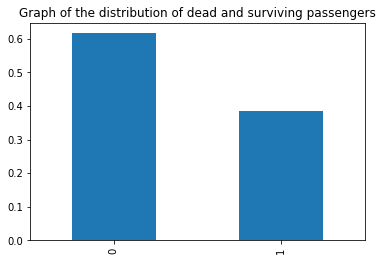

In [23]:
class_frequency = train ['Survived'].value_counts (normalize = bool)
print (class_frequency)
class_frequency.plot (kind = 'bar', title = 'Graph of the distribution of dead and surviving passengers')

Let's look at the distribution of surviving passengers depending on their Pclass, Sex, Age and Embarked

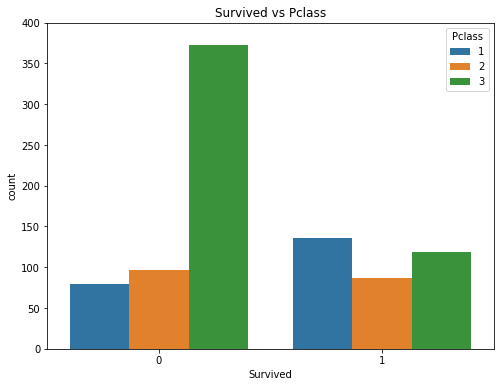

In [24]:
# Pclass
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Pclass', data=train)
ax.set_ylim(0,400)
plt.title("Survived vs Pclass")
plt.show()

We see that there are more survivors from class 1 and 3, but most of the dead are from class 3, so we accept the majority of survivors from class 1.

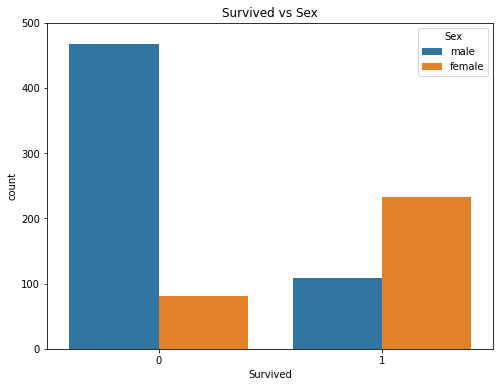

In [25]:
# Sex
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Sex', data=train)
ax.set_ylim(0,500)
plt.title("Survived vs Sex")
plt.show()

Most survivors are women

In [26]:
# Age
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Age', data=train)
ax.set_ylim(0,100)
plt.title("Survived vs Age")
plt.show()

Most survivors range from 0 to 60 years old. There are some values that are out of this range.

In [27]:
# Embarked
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Embarked', data=train)
ax.set_ylim(0,500)
plt.title("Survived vs Embarked")
plt.show()

Passengers Embarked from S were less likely to survived

For clarity, let's add a hypothesis test.

Where:

null hypothesis: the trait is not associated with survivors;

alternative: the trait is associated with survivors.

Let us take the value of the threshold of statistical significance alpha = 0.05.

Let's call the function for the columns of interest to us:

In [28]:
alpha = 0.05

Pclass  Survived  not_Survived
0       1       136            80
1       2        87            97
2       3       119           372

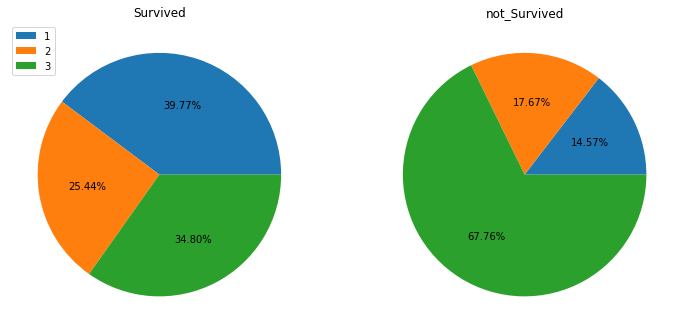

p-значение: 4.5492517112987287e-23
We reject the null hypothesis. The sign is informative


Name  Survived  not_Survived
0                      Abbing, Mr. Anthony         0             1
1              Abbott, Mr. Rossmore Edward         0             1
2         Abbott, Mrs. Stanton (Rosa Hunt)         1             0
3                      Abelson, Mr. Samuel         0             1
4    Abelson, Mrs. Samuel (Hannah Wizosky)         1             0
..                                     ...       ...           ...
886                de Mulder, Mr. Theodore         1             0
887              de Pelsmaeker, Mr. Alfons         0             1
888              del Carlo, Mr. Sebastiano         0             1
889        van Billiard, Mr. Austin Blyler         0             1
890            van Melkebeke, Mr. Philemon         0             1

[891 rows x 3 columns]

Sex  Survived  not_Survived
0  female       233            81
1    male       109           468

p-значение: 0.484248151973633
Failed to reject the null hypothesis. Sign is not informative


p-значение: 1.1973570627755645e-58
We reject the null hypothesis. The sign is informative


Age  Survived  not_Survived
0    0.42         1             0
1    0.67         1             0
2    0.75         2             0
3    0.83         2             0
4    0.92         1             0
..    ...       ...           ...
83  70.00         0             2
84  70.50         0             1
85  71.00         0             2
86  74.00         0             1
87  80.00         1             0

[88 rows x 3 columns]

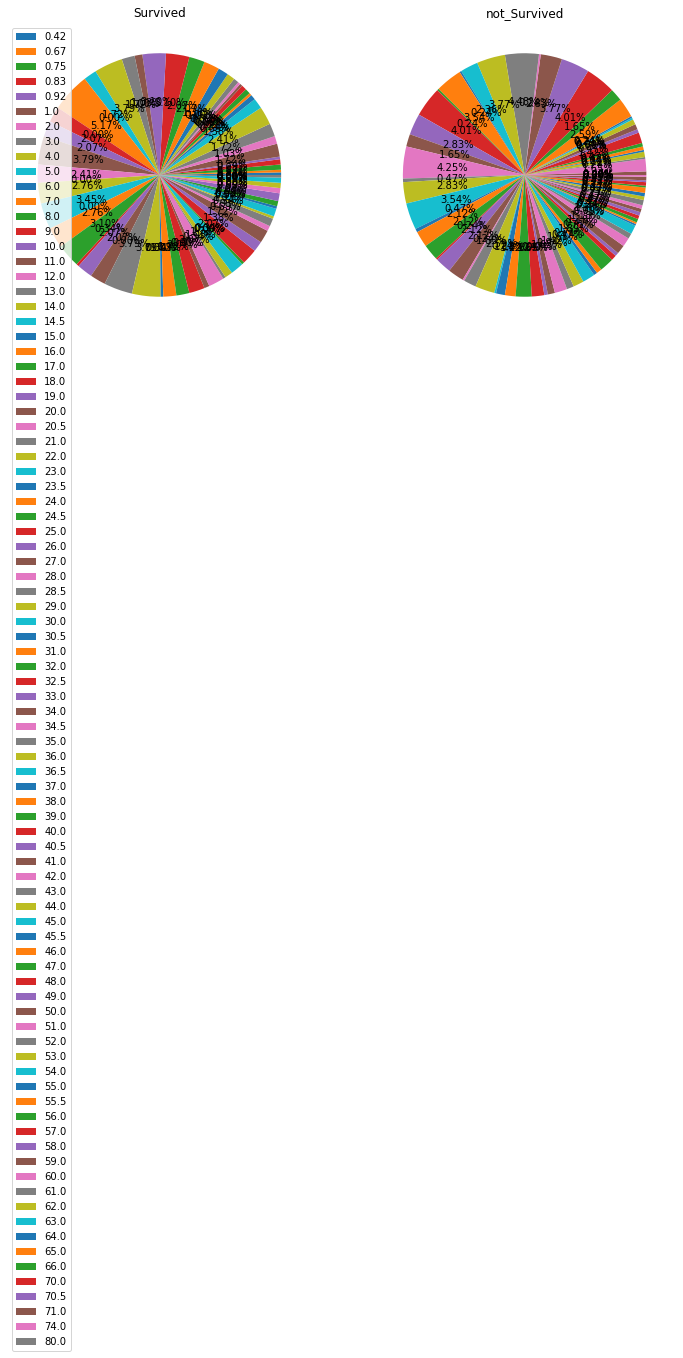

p-значение: 0.10141111018860959
Failed to reject the null hypothesis. Sign is not informative


SibSp  Survived  not_Survived
0      0       210           398
1      1       112            97
2      2        13            15
3      3         4            12
4      4         3            15
5      5         0             5
6      8         0             7

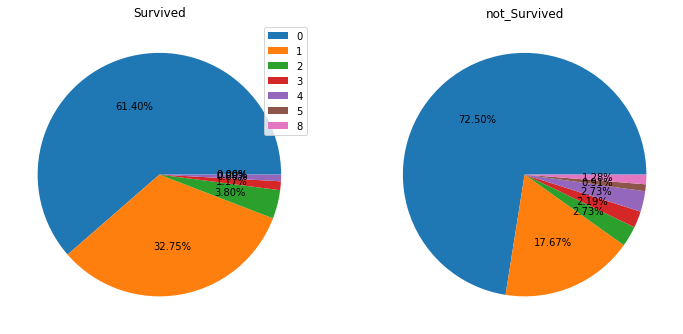

p-значение: 1.5585810465902116e-06
We reject the null hypothesis. The sign is informative


Parch  Survived  not_Survived
0      0       233           445
1      1        65            53
2      2        40            40
3      3         3             2
4      4         0             4
5      5         1             4
6      6         0             1

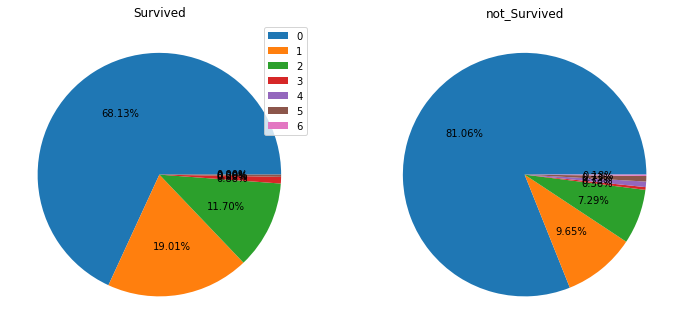

p-значение: 9.703526421039997e-05
We reject the null hypothesis. The sign is informative


Ticket  Survived  not_Survived
0         110152         3             0
1         110413         2             1
2         110465         0             2
3         110564         1             0
4         110813         1             0
..           ...       ...           ...
676   W./C. 6608         0             4
677   W./C. 6609         0             1
678  W.E.P. 5734         0             1
679    W/C 14208         0             1
680    WE/P 5735         1             1

[681 rows x 3 columns]

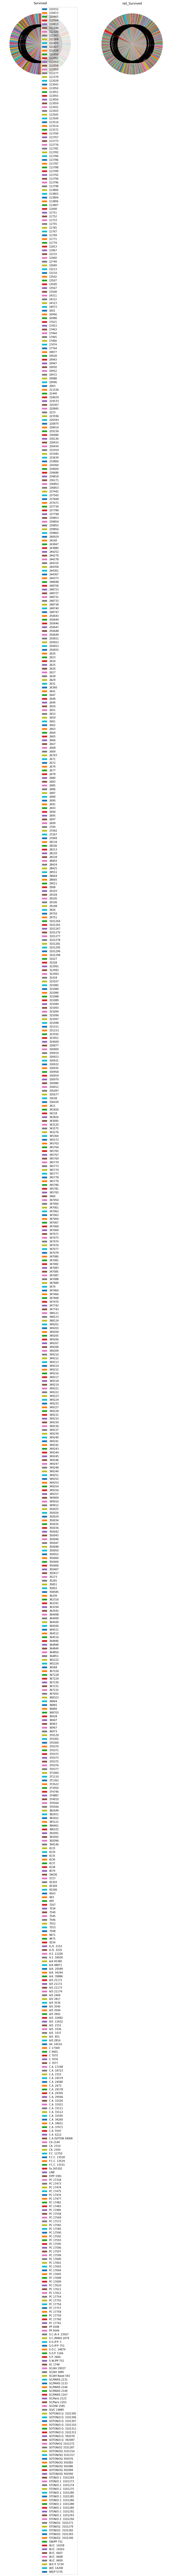

p-значение: 0.01152729601163775
We reject the null hypothesis. The sign is informative


Fare  Survived  not_Survived
0      0.0000         1            14
1      4.0125         0             1
2      5.0000         0             1
3      6.2375         0             1
4      6.4375         0             1
..        ...       ...           ...
243  227.5250         3             1
244  247.5208         1             1
245  262.3750         2             0
246  263.0000         2             2
247  512.3292         3             0

[248 rows x 3 columns]

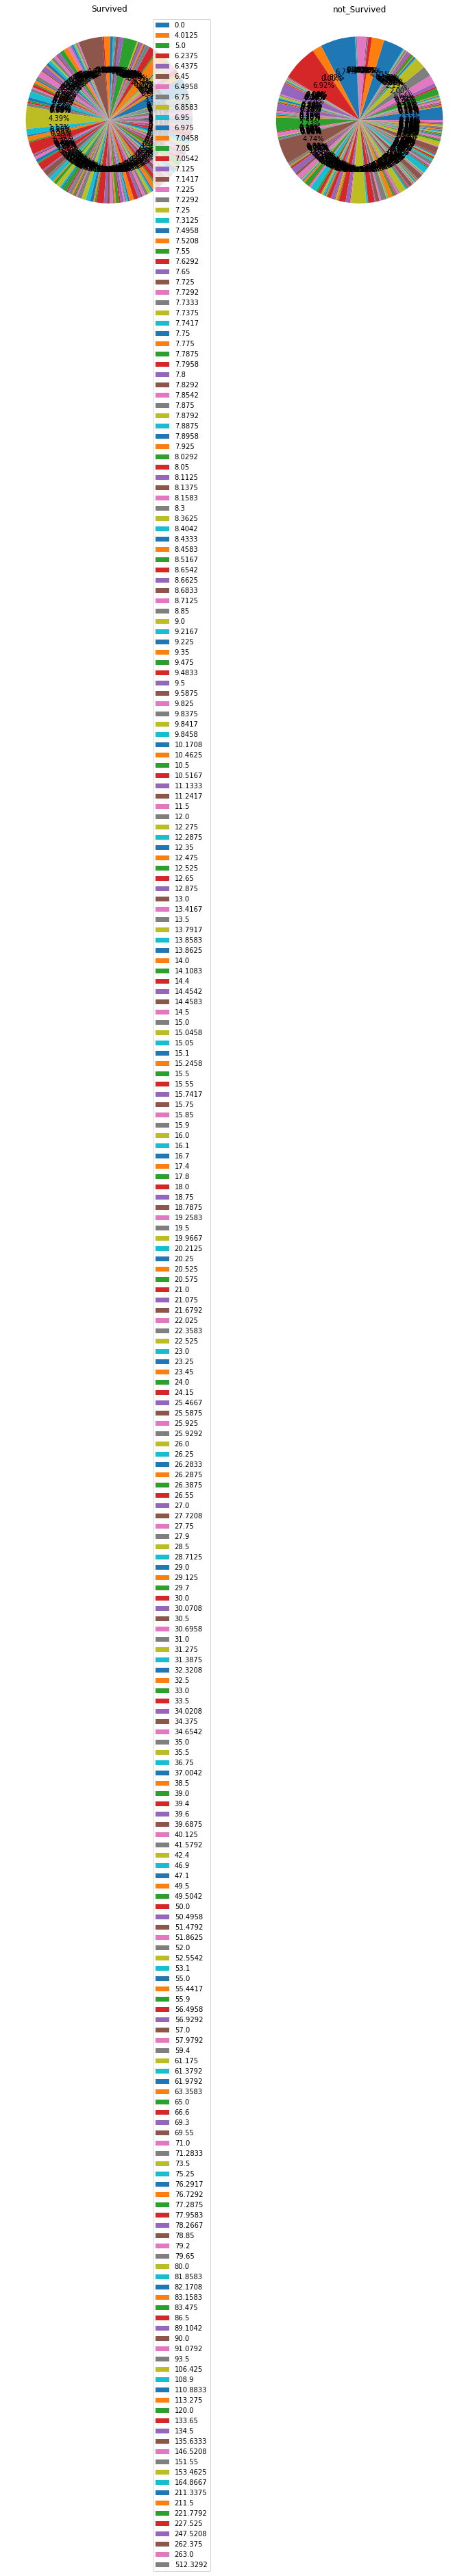

p-значение: 1.1647635739939964e-11
We reject the null hypothesis. The sign is informative


Cabin  Survived  not_Survived
0     A10         0             1
1     A14         0             1
2     A16         1             0
3     A19         0             1
4     A20         1             0
..    ...       ...           ...
142   F33         3             0
143   F38         0             1
144    F4         2             0
145    G6         2             2
146     T         0             1

[147 rows x 3 columns]

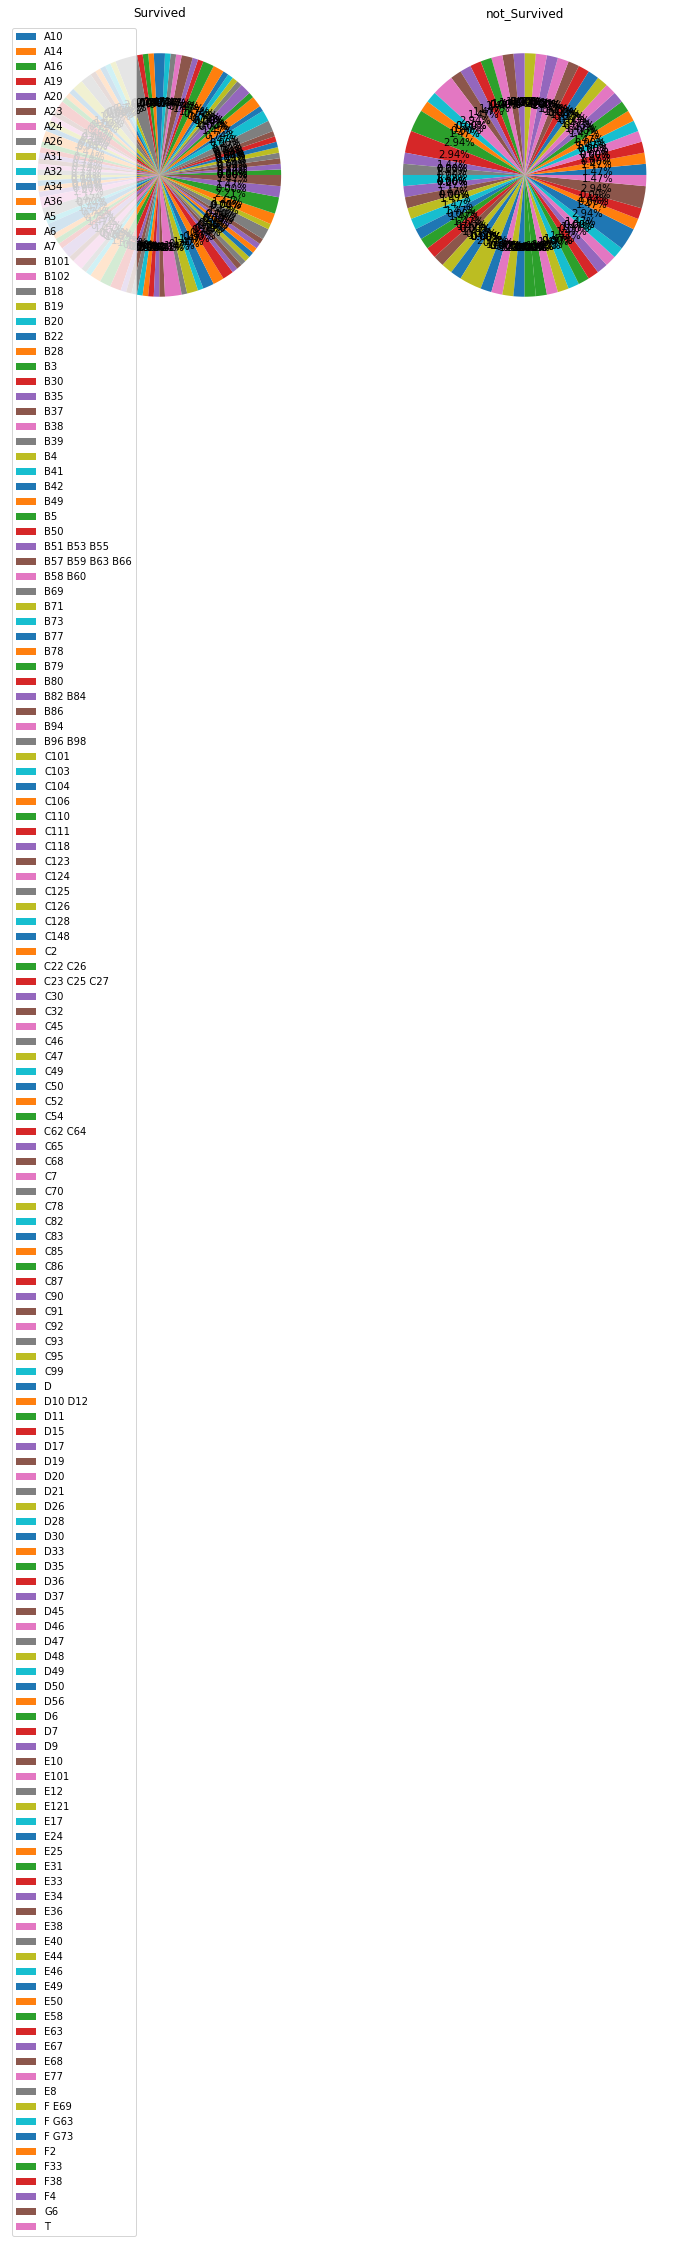

p-значение: 0.18357354976388165
Failed to reject the null hypothesis. Sign is not informative


Embarked  Survived  not_Survived
0        C        93            75
1        Q        30            47
2        S       217           427

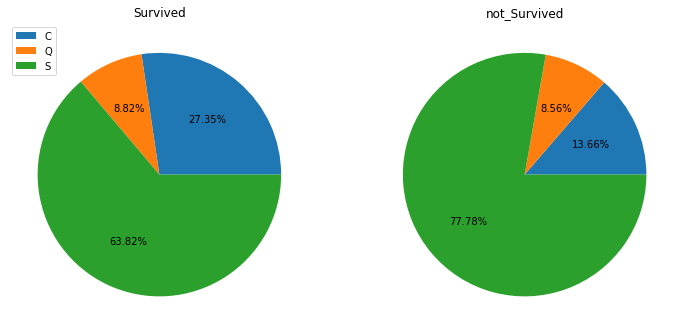

p-значение: 1.769922284120912e-06
We reject the null hypothesis. The sign is informative


In [29]:
category_columns = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',\
                    'Ticket', 'Fare', 'Cabin', 'Embarked']

for i in category_columns:
    table_on_chi2, p_value = merge_chi2(i)
    display(table_on_chi2)
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(table_on_chi2['Survived'], autopct='%1.2f%%')
    plt.legend(labels=table_on_chi2[i], loc='best')
    plt.title('Survived')
   
    
    plt.subplot(1, 2, 2)
    plt.pie(table_on_chi2['not_Survived'], autopct='%1.2f%%')
    plt.title('not_Survived')
    plt.show()
    print('p-значение:', p_value)
    if p_value < alpha:
        print('We reject the null hypothesis. The sign is informative')
    else:
        print('Failed to reject the null hypothesis. Sign is not informative')

The Name field is not informative, we will delete it later.

The Age field is not informative, we will delete it later or convert it.

The Cabin field is not informative, we will delete it later or convert it.

<a id=step_3></a>
## Let's preprocess the data

Fill in the missing values in Embarked with the previously selected value "S"

In [30]:
df['Embarked'] = df['Embarked'].fillna('S')

In [31]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

Fill in the missing Fare value with the average value under such conditions

In [32]:
df['Fare'] = df['Fare'].fillna(df_group['Fare'].mean())

The turn has come to deal with the gaps in the Age field. To do this, create the Title field in which we will place the division by titles from the Name field

In [33]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [34]:
pd.crosstab(df['Title'], df['Sex'])

Sex       female  male
Title                 
Capt           0     1
Col            0     4
Countess       1     0
Don            0     1
Dona           1     0
Dr             1     7
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    61
Miss         260     0
Mlle           2     0
Mme            1     0
Mr             0   757
Mrs          197     0
Ms             2     0
Rev            0     8
Sir            0     1

We group the data with simultaneous replacement with the most common

In [35]:
common = ['Master', 'Mr', 'Miss', 'Mrs']
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].replace('Capt', 'Mr')
df['Title'] = df['Title'].replace('Col', 'Mr')
df['Title'] = df['Title'].replace('Countess', 'Mrs')
df['Title'] = df['Title'].replace('Don', 'Mr')
df['Title'] = df['Title'].replace('Jonkheer', 'Mr')
df['Title'] = df['Title'].replace('Lady', 'Mrs')
df['Title'] = df['Title'].replace('Dona', 'Mrs')
df['Title'] = df['Title'].replace('Major', 'Mr')
df['Title'] = df['Title'].replace('Rev', 'Mr')
df['Title'] = df['Title'].replace('Sir', 'Mr')
df['Title'] = df['Title'].replace('Dr', 'Mr')
# df['Title'] = [x if x in common else 'Rare' for x in df['Title']]

df['Title'].value_counts()

Mr        783
Miss      264
Mrs       201
Master     61
Name: Title, dtype: int64

Let's replace the missing values in the Age field with the median values. To do this, we will select groups by Pclass and Title

In [36]:
grouped = df.groupby(['Sex','Pclass', 'Title'])

In [37]:
grouped.Age.median()

Sex     Pclass  Title 
female  1       Miss      30.0
                Mr        49.0
                Mrs       45.0
        2       Miss      20.0
                Mrs       30.5
        3       Miss      18.0
                Mrs       31.0
male    1       Master     6.0
                Mr        42.0
        2       Master     2.0
                Mr        30.0
        3       Master     6.0
                Mr        26.0
Name: Age, dtype: float64

In [38]:
df.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


We don't know how to fill in the Cabin field, so let's fill it with NA

In [40]:
df.Cabin = df.Cabin.fillna('NA')

In [41]:
df.Cabin = df.Cabin.map(lambda x: x[0])

To store the total values of Parch and SibSp, a Family column was added

In [42]:
df['Family'] = df.Parch + df.SibSp + 1

Encode our string and categorical data

In [43]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

In [44]:
df = pd.concat([df, pd.get_dummies(df.Pclass, prefix="Pclass", drop_first = True),\
                pd.get_dummies(df.Cabin, prefix="Cabin", drop_first = True),\
                pd.get_dummies(df.Embarked, prefix="Emb", drop_first = True),\
                pd.get_dummies(df.Title, prefix="Title", drop_first = True)], axis=1)

Delete the columns we don't need

In [45]:
df.drop(['Pclass', 'Name', 'Ticket', 'Cabin', 'Title', 'Embarked'], axis=1, inplace=True)

<a id=step_4></a>
## Model Training

In [46]:
# Data to be predicted
features_to_be_predicted = df[df.Survived.isnull()]
features_to_be_predicted = features_to_be_predicted.drop(['Survived'], axis = 1)

#Training data
train_data = df.drop(['PassengerId'], axis = 1)
train_data = train_data.dropna()
target = train_data['Survived'].astype(int)
features  = train_data.drop(['Survived'], axis = 1)
train_data.shape

(891, 22)

Let's divide our data into training and test data in a ratio of 1:25

In [47]:
features_train, features_test, target_train, target_test = train_test_split (
    features, target, test_size = 0.25, random_state = 12345)

Train our dataset with a LogisticRegression model

In [48]:
parameters =  {
    'C': optuna.distributions.LogUniformDistribution(1e-7, 10.0),
    'solver': optuna.distributions.CategoricalDistribution(("lbfgs", "saga")),
}
best_model_LogisticRegression, best_params, best_score = tuning_optuna_cv(
    LogisticRegression(), features_train, target_train, params=parameters, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='accuracy', random_state=12345, get_time=False)

[I 2022-10-25 09:49:23,051] A new study created in memory with name: no-name-b292412a-2bce-439e-b8c7-b83f6c713175
[I 2022-10-25 09:49:23,162] Trial 0 finished with value: 0.7095948827292111 and parameters: {'C': 0.1292550302105891, 'solver': 'saga'}. Best is trial 0 with value: 0.7095948827292111.
[I 2022-10-25 09:49:23,230] Trial 1 finished with value: 0.6317248344742453 and parameters: {'C': 8.626130493668947e-07, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7095948827292111.
[I 2022-10-25 09:49:23,332] Trial 2 finished with value: 0.7081023454157782 and parameters: {'C': 0.07327671532110211, 'solver': 'saga'}. Best is trial 0 with value: 0.7095948827292111.
[I 2022-10-25 09:49:23,431] Trial 3 finished with value: 0.6871170463472114 and parameters: {'C': 0.00030883863609133496, 'solver': 'saga'}. Best is trial 0 with value: 0.7095948827292111.
[I 2022-10-25 09:49:23,514] Trial 4 finished with value: 0.6900908988890135 and parameters: {'C': 0.0005148938132715633, 'solver': 'lbfgs

Fitted Model Parameters: {'C': 1.9346628120616662, 'solver': 'lbfgs'}

Received metric: 0.85



In [49]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_LogisticRegression,
                                                                                          features_train,
                                                                                          target_train,
                                                                                          features_test,
                                                                                          target_test)

In [50]:
results = pd.DataFrame ({'model':['LogisticRegression'],\
                         'best_parameters_train':[best_params], 'roc_auc_train':[best_score],\
                       'time_fit':[round(train_time, 2)], 'time_predict':[round(predict_time, 2)],\
                       'accuracy_test':[round(accuracy, 2)], 'precision_test':[round(precision, 2)],\
                       'recall_test':[round(recall, 2)], 'roc_auc_test':[round(roc_auc, 2)]})
results

model                         best_parameters_train  \
0  LogisticRegression  {'C': 1.9346628120616662, 'solver': 'lbfgs'}   

   roc_auc_train  time_fit  time_predict  accuracy_test  precision_test  \
0           0.85      0.04           0.0            0.8            0.81   

   recall_test  roc_auc_test  
0         0.66          0.82

Train our dataset with a DecisionTreeClassifier model

In [51]:
best_model_DecisionTreeClassifier, best_params, best_score = tuning_optuna_cv(
    DecisionTreeClassifier(), features_train, target_train, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-10-25 09:49:24,354] A new study created in memory with name: no-name-62cd628f-93a4-4c41-a802-01d7dac144cf
[I 2022-10-25 09:49:24,392] Trial 0 finished with value: 0.8663709122203098 and parameters: {'min_samples_leaf': 39, 'min_samples_split': 123, 'max_depth': 46}. Best is trial 0 with value: 0.8663709122203098.
[I 2022-10-25 09:49:24,427] Trial 1 finished with value: 0.8594913941480206 and parameters: {'min_samples_leaf': 7, 'min_samples_split': 199, 'max_depth': 6}. Best is trial 0 with value: 0.8663709122203098.
[I 2022-10-25 09:49:24,459] Trial 2 finished with value: 0.8785636833046471 and parameters: {'min_samples_leaf': 37, 'min_samples_split': 58, 'max_depth': 15}. Best is trial 2 with value: 0.8785636833046471.
[I 2022-10-25 09:49:24,489] Trial 3 finished with value: 0.8812641996557659 and parameters: {'min_samples_leaf': 23, 'min_samples_split': 102, 'max_depth': 44}. Best is trial 3 with value: 0.8812641996557659.
[I 2022-10-25 09:49:24,520] Trial 4 finished with val

Fitted Model Parameters: {'min_samples_leaf': 29, 'min_samples_split': 61, 'max_depth': 32}

Received metric: 0.88



In [52]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_DecisionTreeClassifier,
                                                                                          features_train,
                                                                                          target_train,
                                                                                          features_test,
                                                                                          target_test)

In [53]:
results = results.append ({'model':'DecisionTreeClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

model                              best_parameters_train  \
0      LogisticRegression       {'C': 1.9346628120616662, 'solver': 'lbfgs'}   
1  DecisionTreeClassifier  {'min_samples_leaf': 29, 'min_samples_split': ...   

   roc_auc_train  time_fit  time_predict  accuracy_test  precision_test  \
0           0.85      0.04           0.0           0.80            0.81   
1           0.88      0.00           0.0           0.76            0.76   

   recall_test  roc_auc_test  
0         0.66          0.82  
1         0.62          0.83

Train our dataset with a RandomForestClassifier model

In [54]:
best_model_RandomForestClassifier, best_params, best_score = tuning_optuna_cv(
    RandomForestClassifier(), features_train, target_train, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-10-25 09:49:24,729] A new study created in memory with name: no-name-6b414061-c1e1-4ede-9a5f-ded44e3d3539
[I 2022-10-25 09:49:25,853] Trial 0 finished with value: 0.89004446356856 and parameters: {'n_estimators': 165, 'min_samples_split': 16, 'max_depth': 46, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.89004446356856.
[I 2022-10-25 09:49:27,171] Trial 1 finished with value: 0.8892079747561674 and parameters: {'n_estimators': 200, 'min_samples_split': 4, 'max_depth': 37, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.89004446356856.
[I 2022-10-25 09:49:27,793] Trial 2 finished with value: 0.8811724039013195 and parameters: {'n_estimators': 93, 'min_samples_split': 12, 'max_depth': 26, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.89004446356856.
[I 2022-10-25 09:49:28,571] Trial 3 finished with value: 0.878754446356856 and parameters: {'n_estimators': 120, 'min_samples_split': 20, 'max_depth': 19, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.8

Fitted Model Parameters: {'n_estimators': 145, 'min_samples_split': 20, 'max_depth': 15, 'min_samples_leaf': 2}

Received metric: 0.89



In [55]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_RandomForestClassifier,
                                                                                          features_train,
                                                                                          target_train,
                                                                                          features_test,
                                                                                          target_test)

In [56]:
results = results.append ({'model':'RandomForestClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

model                              best_parameters_train  \
0      LogisticRegression       {'C': 1.9346628120616662, 'solver': 'lbfgs'}   
1  DecisionTreeClassifier  {'min_samples_leaf': 29, 'min_samples_split': ...   
2  RandomForestClassifier  {'n_estimators': 145, 'min_samples_split': 20,...   

   roc_auc_train  time_fit  time_predict  accuracy_test  precision_test  \
0           0.85      0.04          0.00           0.80            0.81   
1           0.88      0.00          0.00           0.76            0.76   
2           0.89      0.20          0.02           0.79            0.86   

   recall_test  roc_auc_test  
0         0.66          0.82  
1         0.62          0.83  
2         0.59          0.83

Train our dataset with a CatBoostClassifier model

In [57]:
best_model_CatBoostClassifier, best_params, best_score = tuning_optuna_cv(
    CatBoostClassifier(), features_train, target_train, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-10-25 09:49:34,862] A new study created in memory with name: no-name-add63107-c6b3-4cb2-b20b-e1bac6dc440e


0:	learn: 0.5726544	total: 62.1ms	remaining: 14.4s
1:	learn: 0.5103814	total: 67.9ms	remaining: 7.81s
2:	learn: 0.4435615	total: 78.5ms	remaining: 5.99s
3:	learn: 0.4043356	total: 87.3ms	remaining: 4.98s
4:	learn: 0.3762845	total: 95.5ms	remaining: 4.33s
5:	learn: 0.3577358	total: 104ms	remaining: 3.91s
6:	learn: 0.3373466	total: 112ms	remaining: 3.59s
7:	learn: 0.3312972	total: 113ms	remaining: 3.16s
8:	learn: 0.3168216	total: 121ms	remaining: 3s
9:	learn: 0.3034240	total: 129ms	remaining: 2.87s
10:	learn: 0.2941140	total: 137ms	remaining: 2.76s
11:	learn: 0.2935045	total: 138ms	remaining: 2.53s
12:	learn: 0.2880301	total: 147ms	remaining: 2.47s
13:	learn: 0.2863480	total: 148ms	remaining: 2.3s
14:	learn: 0.2841855	total: 149ms	remaining: 2.15s
15:	learn: 0.2740806	total: 157ms	remaining: 2.12s
16:	learn: 0.2705170	total: 162ms	remaining: 2.04s
17:	learn: 0.2636907	total: 170ms	remaining: 2.02s
18:	learn: 0.2603740	total: 178ms	remaining: 2s
19:	learn: 0.2578676	total: 186ms	remaining

171:	learn: 0.0595319	total: 1.35s	remaining: 470ms
172:	learn: 0.0591928	total: 1.35s	remaining: 462ms
173:	learn: 0.0590598	total: 1.36s	remaining: 454ms
174:	learn: 0.0586730	total: 1.37s	remaining: 447ms
175:	learn: 0.0583065	total: 1.38s	remaining: 439ms
176:	learn: 0.0582524	total: 1.39s	remaining: 431ms
177:	learn: 0.0580672	total: 1.4s	remaining: 423ms
178:	learn: 0.0579356	total: 1.4s	remaining: 415ms
179:	learn: 0.0578904	total: 1.41s	remaining: 407ms
180:	learn: 0.0577171	total: 1.42s	remaining: 399ms
181:	learn: 0.0573403	total: 1.42s	remaining: 391ms
182:	learn: 0.0569002	total: 1.43s	remaining: 384ms
183:	learn: 0.0568230	total: 1.44s	remaining: 376ms
184:	learn: 0.0565711	total: 1.45s	remaining: 368ms
185:	learn: 0.0562907	total: 1.46s	remaining: 360ms
186:	learn: 0.0559851	total: 1.47s	remaining: 353ms
187:	learn: 0.0557299	total: 1.47s	remaining: 345ms
188:	learn: 0.0555557	total: 1.48s	remaining: 337ms
189:	learn: 0.0551060	total: 1.49s	remaining: 329ms
190:	learn: 0.

101:	learn: 0.0875430	total: 762ms	remaining: 971ms
102:	learn: 0.0869781	total: 771ms	remaining: 966ms
103:	learn: 0.0864210	total: 779ms	remaining: 959ms
104:	learn: 0.0848006	total: 787ms	remaining: 952ms
105:	learn: 0.0843368	total: 795ms	remaining: 946ms
106:	learn: 0.0835542	total: 804ms	remaining: 939ms
107:	learn: 0.0829415	total: 812ms	remaining: 932ms
108:	learn: 0.0818634	total: 820ms	remaining: 926ms
109:	learn: 0.0807559	total: 828ms	remaining: 919ms
110:	learn: 0.0800407	total: 836ms	remaining: 912ms
111:	learn: 0.0798140	total: 846ms	remaining: 906ms
112:	learn: 0.0789515	total: 854ms	remaining: 900ms
113:	learn: 0.0785890	total: 863ms	remaining: 894ms
114:	learn: 0.0780384	total: 872ms	remaining: 887ms
115:	learn: 0.0775205	total: 880ms	remaining: 880ms
116:	learn: 0.0773159	total: 888ms	remaining: 873ms
117:	learn: 0.0769400	total: 896ms	remaining: 866ms
118:	learn: 0.0767723	total: 904ms	remaining: 859ms
119:	learn: 0.0758059	total: 913ms	remaining: 852ms
120:	learn: 

29:	learn: 0.2316862	total: 178ms	remaining: 1.2s
30:	learn: 0.2279600	total: 187ms	remaining: 1.21s
31:	learn: 0.2226127	total: 196ms	remaining: 1.22s
32:	learn: 0.2216427	total: 198ms	remaining: 1.19s
33:	learn: 0.2144334	total: 206ms	remaining: 1.2s
34:	learn: 0.2119610	total: 214ms	remaining: 1.2s
35:	learn: 0.2107450	total: 222ms	remaining: 1.21s
36:	learn: 0.2080097	total: 230ms	remaining: 1.21s
37:	learn: 0.2044683	total: 238ms	remaining: 1.22s
38:	learn: 0.2007794	total: 246ms	remaining: 1.22s
39:	learn: 0.1987664	total: 254ms	remaining: 1.22s
40:	learn: 0.1957786	total: 262ms	remaining: 1.22s
41:	learn: 0.1917278	total: 270ms	remaining: 1.22s
42:	learn: 0.1868088	total: 278ms	remaining: 1.22s
43:	learn: 0.1836035	total: 286ms	remaining: 1.22s
44:	learn: 0.1800216	total: 294ms	remaining: 1.22s
45:	learn: 0.1782453	total: 302ms	remaining: 1.22s
46:	learn: 0.1771860	total: 311ms	remaining: 1.22s
47:	learn: 0.1748823	total: 319ms	remaining: 1.22s
48:	learn: 0.1737939	total: 327ms	

191:	learn: 0.0423999	total: 1.48s	remaining: 308ms
192:	learn: 0.0423842	total: 1.49s	remaining: 301ms
193:	learn: 0.0422394	total: 1.5s	remaining: 293ms
194:	learn: 0.0421211	total: 1.5s	remaining: 286ms
195:	learn: 0.0420308	total: 1.51s	remaining: 278ms
196:	learn: 0.0420098	total: 1.52s	remaining: 270ms
197:	learn: 0.0417503	total: 1.53s	remaining: 263ms
198:	learn: 0.0416020	total: 1.54s	remaining: 255ms
199:	learn: 0.0413958	total: 1.55s	remaining: 247ms
200:	learn: 0.0412604	total: 1.55s	remaining: 240ms
201:	learn: 0.0412494	total: 1.56s	remaining: 232ms
202:	learn: 0.0411895	total: 1.57s	remaining: 224ms
203:	learn: 0.0410873	total: 1.58s	remaining: 217ms
204:	learn: 0.0408784	total: 1.59s	remaining: 209ms
205:	learn: 0.0406188	total: 1.6s	remaining: 201ms
206:	learn: 0.0405691	total: 1.6s	remaining: 194ms
207:	learn: 0.0403801	total: 1.61s	remaining: 186ms
208:	learn: 0.0402628	total: 1.62s	remaining: 178ms
209:	learn: 0.0400167	total: 1.63s	remaining: 171ms
210:	learn: 0.03

139:	learn: 0.0642541	total: 1.12s	remaining: 736ms
140:	learn: 0.0639972	total: 1.13s	remaining: 729ms
141:	learn: 0.0639421	total: 1.14s	remaining: 721ms
142:	learn: 0.0637687	total: 1.15s	remaining: 713ms
143:	learn: 0.0632518	total: 1.15s	remaining: 705ms
144:	learn: 0.0627082	total: 1.16s	remaining: 696ms
145:	learn: 0.0625660	total: 1.17s	remaining: 689ms
146:	learn: 0.0623355	total: 1.18s	remaining: 681ms
147:	learn: 0.0622917	total: 1.18s	remaining: 672ms
148:	learn: 0.0621079	total: 1.19s	remaining: 664ms
149:	learn: 0.0615532	total: 1.2s	remaining: 656ms
150:	learn: 0.0615196	total: 1.21s	remaining: 648ms
151:	learn: 0.0611778	total: 1.22s	remaining: 640ms
152:	learn: 0.0609553	total: 1.22s	remaining: 632ms
153:	learn: 0.0607127	total: 1.23s	remaining: 624ms
154:	learn: 0.0601567	total: 1.24s	remaining: 616ms
155:	learn: 0.0600038	total: 1.25s	remaining: 608ms
156:	learn: 0.0597547	total: 1.26s	remaining: 600ms
157:	learn: 0.0595240	total: 1.26s	remaining: 592ms
158:	learn: 0

68:	learn: 0.0998959	total: 515ms	remaining: 1.22s
69:	learn: 0.0991527	total: 524ms	remaining: 1.21s
70:	learn: 0.0962923	total: 533ms	remaining: 1.21s
71:	learn: 0.0950277	total: 541ms	remaining: 1.2s
72:	learn: 0.0928983	total: 549ms	remaining: 1.2s
73:	learn: 0.0921417	total: 558ms	remaining: 1.19s
74:	learn: 0.0893073	total: 566ms	remaining: 1.19s
75:	learn: 0.0883270	total: 575ms	remaining: 1.18s
76:	learn: 0.0879655	total: 583ms	remaining: 1.17s
77:	learn: 0.0878554	total: 591ms	remaining: 1.17s
78:	learn: 0.0856833	total: 600ms	remaining: 1.16s
79:	learn: 0.0849981	total: 612ms	remaining: 1.16s
80:	learn: 0.0841107	total: 621ms	remaining: 1.16s
81:	learn: 0.0825231	total: 629ms	remaining: 1.15s
82:	learn: 0.0820613	total: 638ms	remaining: 1.14s
83:	learn: 0.0808837	total: 646ms	remaining: 1.14s
84:	learn: 0.0800845	total: 655ms	remaining: 1.13s
85:	learn: 0.0793275	total: 663ms	remaining: 1.13s
86:	learn: 0.0787172	total: 672ms	remaining: 1.12s
87:	learn: 0.0765500	total: 680ms

[I 2022-10-25 09:49:44,657] Trial 0 finished with value: 0.86873752151463 and parameters: {'iterations': 232, 'learning_rate': 0.16522559799629474, 'depth': 10}. Best is trial 0 with value: 0.86873752151463.


220:	learn: 0.0338584	total: 1.81s	remaining: 90.2ms
221:	learn: 0.0337234	total: 1.82s	remaining: 82.1ms
222:	learn: 0.0336645	total: 1.83s	remaining: 73.9ms
223:	learn: 0.0334396	total: 1.84s	remaining: 65.7ms
224:	learn: 0.0332769	total: 1.85s	remaining: 57.5ms
225:	learn: 0.0330750	total: 1.85s	remaining: 49.3ms
226:	learn: 0.0330096	total: 1.86s	remaining: 41.1ms
227:	learn: 0.0329812	total: 1.87s	remaining: 32.9ms
228:	learn: 0.0329094	total: 1.88s	remaining: 24.6ms
229:	learn: 0.0328260	total: 1.89s	remaining: 16.4ms
230:	learn: 0.0327432	total: 1.9s	remaining: 8.22ms
231:	learn: 0.0326390	total: 1.91s	remaining: 0us
0:	learn: 0.4236415	total: 959us	remaining: 41.2ms
1:	learn: 0.3819290	total: 2.01ms	remaining: 42.2ms
2:	learn: 0.3608488	total: 2.95ms	remaining: 40.3ms
3:	learn: 0.3519279	total: 3.92ms	remaining: 39.2ms
4:	learn: 0.3404953	total: 5.02ms	remaining: 39.1ms
5:	learn: 0.3357750	total: 6.17ms	remaining: 39.1ms
6:	learn: 0.3334591	total: 7.37ms	remaining: 39ms
7:	lear

[I 2022-10-25 09:49:45,036] Trial 1 finished with value: 0.8663557085484797 and parameters: {'iterations': 44, 'learning_rate': 0.97320861463424, 'depth': 2}. Best is trial 0 with value: 0.86873752151463.


1:	learn: 0.4035805	total: 2.73ms	remaining: 57.2ms
2:	learn: 0.3757730	total: 4.14ms	remaining: 56.6ms
3:	learn: 0.3679870	total: 5.29ms	remaining: 52.9ms
4:	learn: 0.3593948	total: 6.21ms	remaining: 48.4ms
5:	learn: 0.3470638	total: 7.48ms	remaining: 47.4ms
6:	learn: 0.3397162	total: 8.69ms	remaining: 45.9ms
7:	learn: 0.3344773	total: 10.1ms	remaining: 45.3ms
8:	learn: 0.3265861	total: 11.2ms	remaining: 43.7ms
9:	learn: 0.3236272	total: 12.3ms	remaining: 41.6ms
10:	learn: 0.3183419	total: 13.3ms	remaining: 39.9ms
11:	learn: 0.3128305	total: 14.6ms	remaining: 38.9ms
12:	learn: 0.3064215	total: 15.6ms	remaining: 37.3ms
13:	learn: 0.3024414	total: 16.5ms	remaining: 35.5ms
14:	learn: 0.2994545	total: 17.8ms	remaining: 34.3ms
15:	learn: 0.2950210	total: 18.8ms	remaining: 32.9ms
16:	learn: 0.2909437	total: 19.7ms	remaining: 31.3ms
17:	learn: 0.2888477	total: 20.6ms	remaining: 29.8ms
18:	learn: 0.2840772	total: 21.6ms	remaining: 28.4ms
19:	learn: 0.2804439	total: 22.7ms	remaining: 27.2ms
20

183:	learn: 0.3091965	total: 196ms	remaining: 41.5ms
184:	learn: 0.3089760	total: 197ms	remaining: 40.5ms
185:	learn: 0.3088338	total: 198ms	remaining: 39.5ms
186:	learn: 0.3084342	total: 200ms	remaining: 38.5ms
187:	learn: 0.3083543	total: 201ms	remaining: 37.4ms
188:	learn: 0.3082052	total: 202ms	remaining: 36.4ms
189:	learn: 0.3078929	total: 203ms	remaining: 35.3ms
190:	learn: 0.3077817	total: 205ms	remaining: 34.3ms
191:	learn: 0.3076383	total: 206ms	remaining: 33.3ms
192:	learn: 0.3074946	total: 207ms	remaining: 32.2ms
193:	learn: 0.3071669	total: 208ms	remaining: 31.1ms
194:	learn: 0.3066805	total: 209ms	remaining: 30.1ms
195:	learn: 0.3064371	total: 211ms	remaining: 29ms
196:	learn: 0.3063463	total: 212ms	remaining: 28ms
197:	learn: 0.3059295	total: 213ms	remaining: 26.9ms
198:	learn: 0.3058535	total: 214ms	remaining: 25.8ms
199:	learn: 0.3056851	total: 215ms	remaining: 24.8ms
200:	learn: 0.3053160	total: 217ms	remaining: 23.7ms
201:	learn: 0.3051826	total: 218ms	remaining: 22.6

1:	learn: 0.6437376	total: 3.18ms	remaining: 351ms
2:	learn: 0.6228190	total: 4.76ms	remaining: 349ms
3:	learn: 0.6036216	total: 6.2ms	remaining: 339ms
4:	learn: 0.5864195	total: 7.43ms	remaining: 324ms
5:	learn: 0.5751839	total: 8.61ms	remaining: 312ms
6:	learn: 0.5628742	total: 9.85ms	remaining: 304ms
7:	learn: 0.5469799	total: 11.1ms	remaining: 297ms
8:	learn: 0.5332311	total: 12.2ms	remaining: 290ms
9:	learn: 0.5228029	total: 13.4ms	remaining: 285ms
10:	learn: 0.5154265	total: 14.4ms	remaining: 278ms
11:	learn: 0.5045714	total: 15.8ms	remaining: 278ms
12:	learn: 0.4926018	total: 17ms	remaining: 275ms
13:	learn: 0.4819831	total: 18.2ms	remaining: 272ms
14:	learn: 0.4743801	total: 19.6ms	remaining: 272ms
15:	learn: 0.4686059	total: 21.1ms	remaining: 273ms
16:	learn: 0.4651266	total: 22.5ms	remaining: 272ms
17:	learn: 0.4596017	total: 23.5ms	remaining: 268ms
18:	learn: 0.4529366	total: 24.5ms	remaining: 263ms
19:	learn: 0.4463548	total: 25.6ms	remaining: 260ms
20:	learn: 0.4417939	tot

71:	learn: 0.3727278	total: 76.9ms	remaining: 161ms
72:	learn: 0.3719431	total: 78.2ms	remaining: 161ms
73:	learn: 0.3714293	total: 79.5ms	remaining: 160ms
74:	learn: 0.3708361	total: 80.7ms	remaining: 159ms
75:	learn: 0.3703320	total: 81.8ms	remaining: 158ms
76:	learn: 0.3695970	total: 83ms	remaining: 157ms
77:	learn: 0.3690849	total: 84.3ms	remaining: 157ms
78:	learn: 0.3680207	total: 85.6ms	remaining: 156ms
79:	learn: 0.3675733	total: 87ms	remaining: 156ms
80:	learn: 0.3667783	total: 88.2ms	remaining: 155ms
81:	learn: 0.3662742	total: 89.3ms	remaining: 154ms
82:	learn: 0.3656946	total: 90.5ms	remaining: 153ms
83:	learn: 0.3653192	total: 91.8ms	remaining: 152ms
84:	learn: 0.3650721	total: 93ms	remaining: 151ms
85:	learn: 0.3641642	total: 94.4ms	remaining: 150ms
86:	learn: 0.3638196	total: 95.8ms	remaining: 150ms
87:	learn: 0.3633072	total: 97ms	remaining: 149ms
88:	learn: 0.3631320	total: 98ms	remaining: 148ms
89:	learn: 0.3627335	total: 99ms	remaining: 146ms
90:	learn: 0.3624403	tot

[I 2022-10-25 09:49:46,551] Trial 2 finished with value: 0.8949661503155479 and parameters: {'iterations': 223, 'learning_rate': 0.03667544624096302, 'depth': 3}. Best is trial 2 with value: 0.8949661503155479.


146:	learn: 0.3044488	total: 162ms	remaining: 84ms
147:	learn: 0.3039865	total: 164ms	remaining: 83.1ms
148:	learn: 0.3037057	total: 166ms	remaining: 82.2ms
149:	learn: 0.3032752	total: 167ms	remaining: 81.2ms
150:	learn: 0.3028553	total: 168ms	remaining: 80.2ms
151:	learn: 0.3025662	total: 169ms	remaining: 79.1ms
152:	learn: 0.3023145	total: 171ms	remaining: 78ms
153:	learn: 0.3018607	total: 172ms	remaining: 76.9ms
154:	learn: 0.3013765	total: 173ms	remaining: 75.9ms
155:	learn: 0.3012833	total: 174ms	remaining: 74.8ms
156:	learn: 0.3007242	total: 175ms	remaining: 73.7ms
157:	learn: 0.2998875	total: 176ms	remaining: 72.6ms
158:	learn: 0.2996099	total: 178ms	remaining: 71.5ms
159:	learn: 0.2994246	total: 179ms	remaining: 70.5ms
160:	learn: 0.2992632	total: 181ms	remaining: 69.6ms
161:	learn: 0.2990046	total: 182ms	remaining: 68.5ms
162:	learn: 0.2988767	total: 183ms	remaining: 67.4ms
163:	learn: 0.2985250	total: 184ms	remaining: 66.3ms
164:	learn: 0.2983786	total: 185ms	remaining: 65.1

94:	learn: 0.1649068	total: 387ms	remaining: 167ms
95:	learn: 0.1646446	total: 392ms	remaining: 163ms
96:	learn: 0.1638694	total: 396ms	remaining: 159ms
97:	learn: 0.1614750	total: 401ms	remaining: 155ms
98:	learn: 0.1585592	total: 405ms	remaining: 151ms
99:	learn: 0.1558737	total: 409ms	remaining: 147ms
100:	learn: 0.1549230	total: 414ms	remaining: 143ms
101:	learn: 0.1531942	total: 418ms	remaining: 139ms
102:	learn: 0.1530107	total: 423ms	remaining: 135ms
103:	learn: 0.1528991	total: 427ms	remaining: 131ms
104:	learn: 0.1522198	total: 431ms	remaining: 127ms
105:	learn: 0.1514658	total: 435ms	remaining: 123ms
106:	learn: 0.1488504	total: 440ms	remaining: 119ms
107:	learn: 0.1487432	total: 444ms	remaining: 115ms
108:	learn: 0.1467546	total: 448ms	remaining: 111ms
109:	learn: 0.1454583	total: 452ms	remaining: 107ms
110:	learn: 0.1453289	total: 457ms	remaining: 103ms
111:	learn: 0.1440430	total: 461ms	remaining: 98.7ms
112:	learn: 0.1425462	total: 465ms	remaining: 94.7ms
113:	learn: 0.14

133:	learn: 0.1205816	total: 539ms	remaining: 8.04ms
134:	learn: 0.1189953	total: 544ms	remaining: 4.03ms
135:	learn: 0.1187358	total: 549ms	remaining: 0us
0:	learn: 0.6135022	total: 4.14ms	remaining: 560ms
1:	learn: 0.5492889	total: 11.8ms	remaining: 788ms
2:	learn: 0.5030898	total: 18ms	remaining: 796ms
3:	learn: 0.4660048	total: 22.8ms	remaining: 752ms
4:	learn: 0.4348644	total: 27.2ms	remaining: 714ms
5:	learn: 0.4142996	total: 29.3ms	remaining: 635ms
6:	learn: 0.3945003	total: 33.7ms	remaining: 621ms
7:	learn: 0.3779947	total: 37.9ms	remaining: 607ms
8:	learn: 0.3712693	total: 39.2ms	remaining: 553ms
9:	learn: 0.3628220	total: 43.5ms	remaining: 548ms
10:	learn: 0.3560415	total: 45.2ms	remaining: 514ms
11:	learn: 0.3446087	total: 49.6ms	remaining: 513ms
12:	learn: 0.3346783	total: 53.9ms	remaining: 510ms
13:	learn: 0.3274131	total: 58ms	remaining: 505ms
14:	learn: 0.3240553	total: 59.3ms	remaining: 478ms
15:	learn: 0.3163866	total: 62.1ms	remaining: 465ms
16:	learn: 0.3118194	total

54:	learn: 0.2266066	total: 223ms	remaining: 328ms
55:	learn: 0.2251520	total: 227ms	remaining: 325ms
56:	learn: 0.2227168	total: 232ms	remaining: 322ms
57:	learn: 0.2200507	total: 237ms	remaining: 319ms
58:	learn: 0.2180415	total: 241ms	remaining: 315ms
59:	learn: 0.2164193	total: 246ms	remaining: 311ms
60:	learn: 0.2159931	total: 250ms	remaining: 307ms
61:	learn: 0.2148773	total: 254ms	remaining: 303ms
62:	learn: 0.2129915	total: 258ms	remaining: 299ms
63:	learn: 0.2081901	total: 263ms	remaining: 296ms
64:	learn: 0.2048324	total: 267ms	remaining: 292ms
65:	learn: 0.2036351	total: 271ms	remaining: 288ms
66:	learn: 0.2025124	total: 273ms	remaining: 281ms
67:	learn: 0.2001847	total: 277ms	remaining: 277ms
68:	learn: 0.1986229	total: 282ms	remaining: 273ms
69:	learn: 0.1955169	total: 286ms	remaining: 270ms
70:	learn: 0.1932004	total: 290ms	remaining: 266ms
71:	learn: 0.1919329	total: 294ms	remaining: 262ms
72:	learn: 0.1904730	total: 299ms	remaining: 258ms
73:	learn: 0.1891013	total: 303

85:	learn: 0.1405199	total: 358ms	remaining: 208ms
86:	learn: 0.1378108	total: 363ms	remaining: 205ms
87:	learn: 0.1362568	total: 368ms	remaining: 201ms
88:	learn: 0.1358662	total: 372ms	remaining: 197ms
89:	learn: 0.1351861	total: 377ms	remaining: 193ms
90:	learn: 0.1340830	total: 381ms	remaining: 189ms
91:	learn: 0.1324781	total: 386ms	remaining: 185ms
92:	learn: 0.1321608	total: 390ms	remaining: 180ms
93:	learn: 0.1300109	total: 395ms	remaining: 177ms
94:	learn: 0.1290941	total: 400ms	remaining: 172ms
95:	learn: 0.1281802	total: 404ms	remaining: 168ms
96:	learn: 0.1272782	total: 409ms	remaining: 164ms
97:	learn: 0.1262003	total: 413ms	remaining: 160ms
98:	learn: 0.1236984	total: 417ms	remaining: 156ms
99:	learn: 0.1209324	total: 422ms	remaining: 152ms
100:	learn: 0.1202542	total: 426ms	remaining: 148ms
101:	learn: 0.1195140	total: 430ms	remaining: 143ms
102:	learn: 0.1179072	total: 435ms	remaining: 139ms
103:	learn: 0.1169111	total: 440ms	remaining: 135ms
104:	learn: 0.1150395	total

[I 2022-10-25 09:49:49,761] Trial 3 finished with value: 0.8790943775100402 and parameters: {'iterations': 136, 'learning_rate': 0.10216395038172299, 'depth': 9}. Best is trial 2 with value: 0.8949661503155479.


126:	learn: 0.0949339	total: 541ms	remaining: 38.3ms
127:	learn: 0.0944380	total: 546ms	remaining: 34.1ms
128:	learn: 0.0935538	total: 551ms	remaining: 29.9ms
129:	learn: 0.0929736	total: 555ms	remaining: 25.6ms
130:	learn: 0.0925128	total: 559ms	remaining: 21.4ms
131:	learn: 0.0918606	total: 564ms	remaining: 17.1ms
132:	learn: 0.0913803	total: 568ms	remaining: 12.8ms
133:	learn: 0.0903407	total: 572ms	remaining: 8.54ms
134:	learn: 0.0893903	total: 577ms	remaining: 4.27ms
135:	learn: 0.0889728	total: 581ms	remaining: 0us
0:	learn: 0.4870192	total: 1.08ms	remaining: 156ms
1:	learn: 0.4153430	total: 2.25ms	remaining: 161ms
2:	learn: 0.3916346	total: 3.29ms	remaining: 156ms
3:	learn: 0.3743307	total: 4.44ms	remaining: 157ms
4:	learn: 0.3602804	total: 5.51ms	remaining: 154ms
5:	learn: 0.3469810	total: 6.58ms	remaining: 152ms
6:	learn: 0.3435232	total: 7.63ms	remaining: 150ms
7:	learn: 0.3322318	total: 8.68ms	remaining: 149ms
8:	learn: 0.3304992	total: 9.75ms	remaining: 147ms
9:	learn: 0.32

31:	learn: 0.2566134	total: 38.3ms	remaining: 135ms
32:	learn: 0.2531019	total: 39.8ms	remaining: 135ms
33:	learn: 0.2527507	total: 41.2ms	remaining: 134ms
34:	learn: 0.2501855	total: 42.4ms	remaining: 133ms
35:	learn: 0.2472421	total: 43.8ms	remaining: 133ms
36:	learn: 0.2417233	total: 45.1ms	remaining: 132ms
37:	learn: 0.2381929	total: 46.3ms	remaining: 130ms
38:	learn: 0.2349442	total: 47.5ms	remaining: 129ms
39:	learn: 0.2320144	total: 49.2ms	remaining: 129ms
40:	learn: 0.2299585	total: 50.6ms	remaining: 128ms
41:	learn: 0.2260465	total: 52.1ms	remaining: 128ms
42:	learn: 0.2227069	total: 53.4ms	remaining: 127ms
43:	learn: 0.2201709	total: 54.6ms	remaining: 125ms
44:	learn: 0.2166663	total: 55.7ms	remaining: 124ms
45:	learn: 0.2160038	total: 56.8ms	remaining: 122ms
46:	learn: 0.2117557	total: 58ms	remaining: 121ms
47:	learn: 0.2081573	total: 59.1ms	remaining: 119ms
48:	learn: 0.2046172	total: 60.2ms	remaining: 118ms
49:	learn: 0.2030404	total: 61.4ms	remaining: 117ms
50:	learn: 0.2

143:	learn: 0.0836047	total: 174ms	remaining: 1.21ms
144:	learn: 0.0833745	total: 175ms	remaining: 0us
0:	learn: 0.5059394	total: 1.13ms	remaining: 163ms
1:	learn: 0.4333720	total: 2.29ms	remaining: 164ms
2:	learn: 0.4184910	total: 3.16ms	remaining: 150ms
3:	learn: 0.4077862	total: 4.3ms	remaining: 152ms
4:	learn: 0.3872062	total: 5.46ms	remaining: 153ms
5:	learn: 0.3734866	total: 6.6ms	remaining: 153ms
6:	learn: 0.3659016	total: 7.79ms	remaining: 154ms
7:	learn: 0.3608454	total: 8.9ms	remaining: 152ms
8:	learn: 0.3543484	total: 10.1ms	remaining: 152ms
9:	learn: 0.3455344	total: 11.2ms	remaining: 151ms
10:	learn: 0.3430348	total: 12.3ms	remaining: 150ms
11:	learn: 0.3364758	total: 13.4ms	remaining: 149ms
12:	learn: 0.3352254	total: 14.6ms	remaining: 148ms
13:	learn: 0.3327367	total: 15.9ms	remaining: 149ms
14:	learn: 0.3297884	total: 17.1ms	remaining: 148ms
15:	learn: 0.3250523	total: 18.3ms	remaining: 147ms
16:	learn: 0.3199860	total: 19.4ms	remaining: 146ms
17:	learn: 0.3189277	total

[I 2022-10-25 09:49:50,938] Trial 4 finished with value: 0.8796279403327596 and parameters: {'iterations': 145, 'learning_rate': 0.336169501733233, 'depth': 4}. Best is trial 2 with value: 0.8949661503155479.


76:	learn: 0.1371893	total: 91.8ms	remaining: 81.1ms
77:	learn: 0.1365600	total: 93.4ms	remaining: 80.3ms
78:	learn: 0.1338101	total: 94.7ms	remaining: 79.2ms
79:	learn: 0.1324819	total: 96.2ms	remaining: 78.2ms
80:	learn: 0.1300767	total: 97.4ms	remaining: 77ms
81:	learn: 0.1287079	total: 99ms	remaining: 76.1ms
82:	learn: 0.1265505	total: 100ms	remaining: 75ms
83:	learn: 0.1249482	total: 102ms	remaining: 74ms
84:	learn: 0.1242387	total: 103ms	remaining: 73ms
85:	learn: 0.1237032	total: 105ms	remaining: 72ms
86:	learn: 0.1222989	total: 106ms	remaining: 70.8ms
87:	learn: 0.1211669	total: 108ms	remaining: 69.8ms
88:	learn: 0.1190335	total: 109ms	remaining: 68.6ms
89:	learn: 0.1173111	total: 110ms	remaining: 67.3ms
90:	learn: 0.1167589	total: 111ms	remaining: 66ms
91:	learn: 0.1156195	total: 112ms	remaining: 64.7ms
92:	learn: 0.1152698	total: 113ms	remaining: 63.4ms
93:	learn: 0.1142263	total: 115ms	remaining: 62.1ms
94:	learn: 0.1129150	total: 116ms	remaining: 60.9ms
95:	learn: 0.1124454

133:	learn: 0.0654354	total: 192ms	remaining: 135ms
134:	learn: 0.0649060	total: 194ms	remaining: 133ms
135:	learn: 0.0645195	total: 195ms	remaining: 132ms
136:	learn: 0.0641483	total: 197ms	remaining: 131ms
137:	learn: 0.0638313	total: 198ms	remaining: 129ms
138:	learn: 0.0632662	total: 199ms	remaining: 127ms
139:	learn: 0.0630777	total: 200ms	remaining: 126ms
140:	learn: 0.0628954	total: 202ms	remaining: 125ms
141:	learn: 0.0626602	total: 203ms	remaining: 123ms
142:	learn: 0.0624472	total: 205ms	remaining: 122ms
143:	learn: 0.0624272	total: 206ms	remaining: 120ms
144:	learn: 0.0620568	total: 207ms	remaining: 119ms
145:	learn: 0.0616169	total: 209ms	remaining: 117ms
146:	learn: 0.0613878	total: 210ms	remaining: 116ms
147:	learn: 0.0613597	total: 211ms	remaining: 114ms
148:	learn: 0.0607936	total: 212ms	remaining: 113ms
149:	learn: 0.0603320	total: 213ms	remaining: 111ms
150:	learn: 0.0600582	total: 215ms	remaining: 109ms
151:	learn: 0.0600426	total: 216ms	remaining: 108ms
152:	learn: 

164:	learn: 0.0585835	total: 195ms	remaining: 74.6ms
165:	learn: 0.0582534	total: 197ms	remaining: 73.6ms
166:	learn: 0.0578904	total: 199ms	remaining: 72.5ms
167:	learn: 0.0573329	total: 200ms	remaining: 71.4ms
168:	learn: 0.0569608	total: 201ms	remaining: 70.2ms
169:	learn: 0.0567764	total: 203ms	remaining: 69.1ms
170:	learn: 0.0565554	total: 204ms	remaining: 68ms
171:	learn: 0.0564750	total: 205ms	remaining: 66.8ms
172:	learn: 0.0563751	total: 207ms	remaining: 65.8ms
173:	learn: 0.0563750	total: 208ms	remaining: 64.6ms
174:	learn: 0.0562300	total: 209ms	remaining: 63.4ms
175:	learn: 0.0558457	total: 211ms	remaining: 62.2ms
176:	learn: 0.0558340	total: 212ms	remaining: 61.1ms
177:	learn: 0.0554243	total: 213ms	remaining: 59.9ms
178:	learn: 0.0549750	total: 215ms	remaining: 58.7ms
179:	learn: 0.0548608	total: 216ms	remaining: 57.6ms
180:	learn: 0.0543648	total: 217ms	remaining: 56.4ms
181:	learn: 0.0543235	total: 218ms	remaining: 55.2ms
182:	learn: 0.0542070	total: 219ms	remaining: 54

208:	learn: 0.0375957	total: 242ms	remaining: 22ms
209:	learn: 0.0373846	total: 244ms	remaining: 20.9ms
210:	learn: 0.0372969	total: 245ms	remaining: 19.7ms
211:	learn: 0.0372967	total: 246ms	remaining: 18.6ms
212:	learn: 0.0372947	total: 248ms	remaining: 17.4ms
213:	learn: 0.0372924	total: 249ms	remaining: 16.3ms
214:	learn: 0.0372904	total: 250ms	remaining: 15.1ms
215:	learn: 0.0372869	total: 251ms	remaining: 13.9ms
216:	learn: 0.0371173	total: 252ms	remaining: 12.8ms
217:	learn: 0.0369636	total: 254ms	remaining: 11.6ms
218:	learn: 0.0368331	total: 255ms	remaining: 10.5ms
219:	learn: 0.0366013	total: 256ms	remaining: 9.31ms
220:	learn: 0.0363527	total: 257ms	remaining: 8.15ms
221:	learn: 0.0361472	total: 259ms	remaining: 7ms
222:	learn: 0.0360221	total: 260ms	remaining: 5.84ms
223:	learn: 0.0357948	total: 262ms	remaining: 4.67ms
224:	learn: 0.0356288	total: 263ms	remaining: 3.5ms
225:	learn: 0.0354826	total: 264ms	remaining: 2.33ms
226:	learn: 0.0353117	total: 265ms	remaining: 1.17ms

0:	learn: 0.4027586	total: 1.68ms	remaining: 382ms
1:	learn: 0.3561044	total: 3.59ms	remaining: 405ms
2:	learn: 0.3301047	total: 4.84ms	remaining: 363ms
3:	learn: 0.3180090	total: 5.99ms	remaining: 335ms
4:	learn: 0.3125128	total: 7.18ms	remaining: 320ms
5:	learn: 0.3001720	total: 8.57ms	remaining: 317ms
6:	learn: 0.2929121	total: 9.74ms	remaining: 308ms
7:	learn: 0.2809620	total: 10.9ms	remaining: 299ms
8:	learn: 0.2786548	total: 12ms	remaining: 292ms
9:	learn: 0.2699746	total: 13.3ms	remaining: 290ms
10:	learn: 0.2650725	total: 14.7ms	remaining: 290ms
11:	learn: 0.2558636	total: 16ms	remaining: 289ms
12:	learn: 0.2513643	total: 17.1ms	remaining: 283ms
13:	learn: 0.2429988	total: 18.4ms	remaining: 282ms
14:	learn: 0.2372805	total: 19.7ms	remaining: 279ms
15:	learn: 0.2341506	total: 20.8ms	remaining: 275ms
16:	learn: 0.2299963	total: 22ms	remaining: 273ms
17:	learn: 0.2223476	total: 23.1ms	remaining: 270ms
18:	learn: 0.2195382	total: 24.3ms	remaining: 267ms
19:	learn: 0.2191757	total: 

[I 2022-10-25 09:49:52,688] Trial 5 finished with value: 0.8742687894434882 and parameters: {'iterations': 228, 'learning_rate': 0.5767803730680693, 'depth': 4}. Best is trial 2 with value: 0.8949661503155479.


130:	learn: 0.0482874	total: 158ms	remaining: 117ms
131:	learn: 0.0480841	total: 159ms	remaining: 116ms
132:	learn: 0.0476552	total: 161ms	remaining: 115ms
133:	learn: 0.0473381	total: 162ms	remaining: 113ms
134:	learn: 0.0470224	total: 163ms	remaining: 112ms
135:	learn: 0.0462232	total: 165ms	remaining: 111ms
136:	learn: 0.0456770	total: 166ms	remaining: 110ms
137:	learn: 0.0450973	total: 168ms	remaining: 109ms
138:	learn: 0.0447111	total: 169ms	remaining: 108ms
139:	learn: 0.0444321	total: 170ms	remaining: 107ms
140:	learn: 0.0441024	total: 172ms	remaining: 106ms
141:	learn: 0.0439713	total: 173ms	remaining: 105ms
142:	learn: 0.0438468	total: 175ms	remaining: 104ms
143:	learn: 0.0438039	total: 176ms	remaining: 103ms
144:	learn: 0.0433112	total: 177ms	remaining: 101ms
145:	learn: 0.0430210	total: 178ms	remaining: 100ms
146:	learn: 0.0429782	total: 179ms	remaining: 98.7ms
147:	learn: 0.0424873	total: 180ms	remaining: 97.4ms
148:	learn: 0.0421837	total: 182ms	remaining: 96.3ms
149:	lear

88:	learn: 0.2780636	total: 187ms	remaining: 183ms
89:	learn: 0.2774555	total: 190ms	remaining: 181ms
90:	learn: 0.2767421	total: 192ms	remaining: 179ms
91:	learn: 0.2759478	total: 194ms	remaining: 178ms
92:	learn: 0.2755353	total: 197ms	remaining: 176ms
93:	learn: 0.2745410	total: 199ms	remaining: 174ms
94:	learn: 0.2738314	total: 202ms	remaining: 172ms
95:	learn: 0.2736160	total: 204ms	remaining: 170ms
96:	learn: 0.2729136	total: 206ms	remaining: 168ms
97:	learn: 0.2723811	total: 208ms	remaining: 166ms
98:	learn: 0.2722688	total: 209ms	remaining: 163ms
99:	learn: 0.2721938	total: 210ms	remaining: 160ms
100:	learn: 0.2714552	total: 212ms	remaining: 158ms
101:	learn: 0.2700495	total: 214ms	remaining: 155ms
102:	learn: 0.2685443	total: 216ms	remaining: 153ms
103:	learn: 0.2682150	total: 218ms	remaining: 151ms
104:	learn: 0.2679397	total: 220ms	remaining: 149ms
105:	learn: 0.2674315	total: 222ms	remaining: 146ms
106:	learn: 0.2667477	total: 224ms	remaining: 144ms
107:	learn: 0.2660053	to

87:	learn: 0.2823217	total: 171ms	remaining: 171ms
88:	learn: 0.2821397	total: 173ms	remaining: 170ms
89:	learn: 0.2816304	total: 176ms	remaining: 168ms
90:	learn: 0.2809104	total: 178ms	remaining: 166ms
91:	learn: 0.2796317	total: 180ms	remaining: 164ms
92:	learn: 0.2789096	total: 182ms	remaining: 163ms
93:	learn: 0.2782824	total: 185ms	remaining: 161ms
94:	learn: 0.2780728	total: 186ms	remaining: 159ms
95:	learn: 0.2772502	total: 188ms	remaining: 157ms
96:	learn: 0.2769989	total: 190ms	remaining: 155ms
97:	learn: 0.2763980	total: 192ms	remaining: 153ms
98:	learn: 0.2751403	total: 194ms	remaining: 151ms
99:	learn: 0.2745083	total: 196ms	remaining: 149ms
100:	learn: 0.2743340	total: 198ms	remaining: 147ms
101:	learn: 0.2737917	total: 200ms	remaining: 145ms
102:	learn: 0.2731007	total: 202ms	remaining: 143ms
103:	learn: 0.2723581	total: 204ms	remaining: 141ms
104:	learn: 0.2715891	total: 205ms	remaining: 139ms
105:	learn: 0.2711225	total: 207ms	remaining: 137ms
106:	learn: 0.2708077	tot

84:	learn: 0.2800297	total: 178ms	remaining: 191ms
85:	learn: 0.2794676	total: 181ms	remaining: 189ms
86:	learn: 0.2787314	total: 183ms	remaining: 187ms
87:	learn: 0.2779815	total: 185ms	remaining: 185ms
88:	learn: 0.2777811	total: 187ms	remaining: 183ms
89:	learn: 0.2771190	total: 189ms	remaining: 181ms
90:	learn: 0.2762147	total: 191ms	remaining: 179ms
91:	learn: 0.2751739	total: 194ms	remaining: 177ms
92:	learn: 0.2744174	total: 196ms	remaining: 175ms
93:	learn: 0.2730446	total: 198ms	remaining: 172ms
94:	learn: 0.2718762	total: 200ms	remaining: 170ms
95:	learn: 0.2712739	total: 202ms	remaining: 168ms
96:	learn: 0.2708451	total: 204ms	remaining: 166ms
97:	learn: 0.2703886	total: 205ms	remaining: 163ms
98:	learn: 0.2697700	total: 207ms	remaining: 161ms
99:	learn: 0.2697171	total: 209ms	remaining: 158ms
100:	learn: 0.2684665	total: 210ms	remaining: 156ms
101:	learn: 0.2678315	total: 212ms	remaining: 154ms
102:	learn: 0.2675793	total: 214ms	remaining: 152ms
103:	learn: 0.2671263	total:

87:	learn: 0.2887651	total: 178ms	remaining: 178ms
88:	learn: 0.2882401	total: 180ms	remaining: 176ms
89:	learn: 0.2875101	total: 182ms	remaining: 174ms
90:	learn: 0.2869748	total: 185ms	remaining: 172ms
91:	learn: 0.2864551	total: 187ms	remaining: 170ms
92:	learn: 0.2860381	total: 189ms	remaining: 169ms
93:	learn: 0.2854635	total: 192ms	remaining: 167ms
94:	learn: 0.2848344	total: 194ms	remaining: 165ms
95:	learn: 0.2846047	total: 196ms	remaining: 163ms
96:	learn: 0.2838284	total: 198ms	remaining: 161ms
97:	learn: 0.2828458	total: 200ms	remaining: 160ms
98:	learn: 0.2813948	total: 202ms	remaining: 157ms
99:	learn: 0.2810685	total: 204ms	remaining: 155ms
100:	learn: 0.2801857	total: 206ms	remaining: 153ms
101:	learn: 0.2796453	total: 208ms	remaining: 151ms
102:	learn: 0.2782357	total: 210ms	remaining: 149ms
103:	learn: 0.2782005	total: 211ms	remaining: 146ms
104:	learn: 0.2777034	total: 214ms	remaining: 144ms
105:	learn: 0.2767088	total: 216ms	remaining: 143ms
106:	learn: 0.2760948	tot

71:	learn: 0.2685046	total: 146ms	remaining: 211ms
72:	learn: 0.2673078	total: 148ms	remaining: 209ms
73:	learn: 0.2670351	total: 151ms	remaining: 208ms
74:	learn: 0.2662309	total: 153ms	remaining: 206ms
75:	learn: 0.2656055	total: 155ms	remaining: 204ms
76:	learn: 0.2648131	total: 158ms	remaining: 203ms
77:	learn: 0.2646986	total: 159ms	remaining: 200ms
78:	learn: 0.2632880	total: 161ms	remaining: 198ms
79:	learn: 0.2615817	total: 163ms	remaining: 196ms
80:	learn: 0.2608653	total: 165ms	remaining: 194ms
81:	learn: 0.2601430	total: 167ms	remaining: 192ms
82:	learn: 0.2596996	total: 169ms	remaining: 189ms
83:	learn: 0.2585783	total: 171ms	remaining: 187ms
84:	learn: 0.2563190	total: 174ms	remaining: 186ms
85:	learn: 0.2553713	total: 176ms	remaining: 184ms
86:	learn: 0.2548359	total: 178ms	remaining: 182ms
87:	learn: 0.2540572	total: 180ms	remaining: 180ms
88:	learn: 0.2535775	total: 182ms	remaining: 177ms
89:	learn: 0.2530879	total: 183ms	remaining: 175ms
90:	learn: 0.2527511	total: 185

[I 2022-10-25 09:49:54,830] Trial 6 finished with value: 0.8921265060240964 and parameters: {'iterations': 176, 'learning_rate': 0.03995619683071353, 'depth': 7}. Best is trial 2 with value: 0.8949661503155479.


158:	learn: 0.2093174	total: 323ms	remaining: 34.6ms
159:	learn: 0.2083332	total: 326ms	remaining: 32.6ms
160:	learn: 0.2078575	total: 328ms	remaining: 30.5ms
161:	learn: 0.2073117	total: 330ms	remaining: 28.5ms
162:	learn: 0.2067900	total: 333ms	remaining: 26.5ms
163:	learn: 0.2063939	total: 335ms	remaining: 24.5ms
164:	learn: 0.2057983	total: 337ms	remaining: 22.5ms
165:	learn: 0.2055073	total: 339ms	remaining: 20.4ms
166:	learn: 0.2050900	total: 341ms	remaining: 18.4ms
167:	learn: 0.2046672	total: 343ms	remaining: 16.3ms
168:	learn: 0.2041624	total: 345ms	remaining: 14.3ms
169:	learn: 0.2036382	total: 347ms	remaining: 12.3ms
170:	learn: 0.2023948	total: 349ms	remaining: 10.2ms
171:	learn: 0.2008454	total: 351ms	remaining: 8.17ms
172:	learn: 0.2000573	total: 353ms	remaining: 6.12ms
173:	learn: 0.1995871	total: 355ms	remaining: 4.08ms
174:	learn: 0.1991010	total: 357ms	remaining: 2.04ms
175:	learn: 0.1986212	total: 359ms	remaining: 0us
0:	learn: 0.6760439	total: 1.26ms	remaining: 297m

1:	learn: 0.6640290	total: 2.33ms	remaining: 273ms
2:	learn: 0.6518999	total: 3.52ms	remaining: 273ms
3:	learn: 0.6392836	total: 4.59ms	remaining: 267ms
4:	learn: 0.6290331	total: 5.75ms	remaining: 266ms
5:	learn: 0.6182776	total: 6.61ms	remaining: 253ms
6:	learn: 0.6084062	total: 7.65ms	remaining: 250ms
7:	learn: 0.5993500	total: 8.63ms	remaining: 246ms
8:	learn: 0.5910441	total: 9.58ms	remaining: 242ms
9:	learn: 0.5834164	total: 10.4ms	remaining: 236ms
10:	learn: 0.5772455	total: 11.2ms	remaining: 230ms
11:	learn: 0.5707326	total: 12ms	remaining: 225ms
12:	learn: 0.5647622	total: 12.9ms	remaining: 221ms
13:	learn: 0.5590670	total: 13.7ms	remaining: 218ms
14:	learn: 0.5538239	total: 14.6ms	remaining: 216ms
15:	learn: 0.5489898	total: 15.6ms	remaining: 215ms
16:	learn: 0.5445013	total: 16.5ms	remaining: 213ms
17:	learn: 0.5403708	total: 17.5ms	remaining: 211ms
18:	learn: 0.5365695	total: 18.4ms	remaining: 210ms
19:	learn: 0.5326320	total: 19.3ms	remaining: 209ms
20:	learn: 0.5285471	to

188:	learn: 0.3924958	total: 158ms	remaining: 39.3ms
189:	learn: 0.3922480	total: 159ms	remaining: 38.5ms
190:	learn: 0.3920216	total: 160ms	remaining: 37.7ms
191:	learn: 0.3918713	total: 161ms	remaining: 36.9ms
192:	learn: 0.3917582	total: 162ms	remaining: 36.1ms
193:	learn: 0.3915074	total: 163ms	remaining: 35.3ms
194:	learn: 0.3912875	total: 164ms	remaining: 34.4ms
195:	learn: 0.3910578	total: 165ms	remaining: 33.6ms
196:	learn: 0.3908252	total: 166ms	remaining: 32.8ms
197:	learn: 0.3906437	total: 167ms	remaining: 32ms
198:	learn: 0.3904336	total: 168ms	remaining: 31.2ms
199:	learn: 0.3902156	total: 169ms	remaining: 30.3ms
200:	learn: 0.3899943	total: 169ms	remaining: 29.5ms
201:	learn: 0.3897911	total: 170ms	remaining: 28.7ms
202:	learn: 0.3895689	total: 172ms	remaining: 27.9ms
203:	learn: 0.3893391	total: 173ms	remaining: 27.1ms
204:	learn: 0.3891345	total: 174ms	remaining: 26.3ms
205:	learn: 0.3889218	total: 174ms	remaining: 25.4ms
206:	learn: 0.3888125	total: 175ms	remaining: 24

110:	learn: 0.4032494	total: 90.9ms	remaining: 102ms
111:	learn: 0.4027858	total: 91.7ms	remaining: 102ms
112:	learn: 0.4023439	total: 93ms	remaining: 101ms
113:	learn: 0.4020284	total: 93.9ms	remaining: 100ms
114:	learn: 0.4016059	total: 94.8ms	remaining: 99.7ms
115:	learn: 0.4011840	total: 95.6ms	remaining: 98.9ms
116:	learn: 0.4005161	total: 96.6ms	remaining: 98.3ms
117:	learn: 0.4001308	total: 97.5ms	remaining: 97.5ms
118:	learn: 0.3997252	total: 98.4ms	remaining: 96.8ms
119:	learn: 0.3990960	total: 99.6ms	remaining: 96.3ms
120:	learn: 0.3985194	total: 101ms	remaining: 95.6ms
121:	learn: 0.3982675	total: 102ms	remaining: 94.9ms
122:	learn: 0.3980364	total: 102ms	remaining: 94.2ms
123:	learn: 0.3975229	total: 103ms	remaining: 93.4ms
124:	learn: 0.3968653	total: 105ms	remaining: 93ms
125:	learn: 0.3963918	total: 106ms	remaining: 92.3ms
126:	learn: 0.3960376	total: 107ms	remaining: 91.4ms
127:	learn: 0.3956079	total: 107ms	remaining: 90.6ms
128:	learn: 0.3951643	total: 108ms	remaining

210:	learn: 0.3968014	total: 192ms	remaining: 22.7ms
211:	learn: 0.3965939	total: 193ms	remaining: 21.8ms
212:	learn: 0.3964003	total: 194ms	remaining: 20.9ms
213:	learn: 0.3962049	total: 195ms	remaining: 20ms
214:	learn: 0.3960491	total: 195ms	remaining: 19.1ms
215:	learn: 0.3958543	total: 196ms	remaining: 18.2ms
216:	learn: 0.3956727	total: 197ms	remaining: 17.3ms
217:	learn: 0.3954849	total: 198ms	remaining: 16.4ms
218:	learn: 0.3952989	total: 199ms	remaining: 15.4ms
219:	learn: 0.3951180	total: 200ms	remaining: 14.5ms
220:	learn: 0.3949524	total: 201ms	remaining: 13.6ms
221:	learn: 0.3948456	total: 202ms	remaining: 12.7ms
222:	learn: 0.3946925	total: 203ms	remaining: 11.8ms
223:	learn: 0.3945908	total: 204ms	remaining: 10.9ms
224:	learn: 0.3944048	total: 205ms	remaining: 10ms
225:	learn: 0.3942346	total: 206ms	remaining: 9.12ms
226:	learn: 0.3940856	total: 207ms	remaining: 8.22ms
227:	learn: 0.3940228	total: 208ms	remaining: 7.31ms
228:	learn: 0.3938687	total: 209ms	remaining: 6.4m

[I 2022-10-25 09:49:56,172] Trial 7 finished with value: 0.891261617900172 and parameters: {'iterations': 236, 'learning_rate': 0.03757660312047133, 'depth': 1}. Best is trial 2 with value: 0.8949661503155479.


144:	learn: 0.3814464	total: 119ms	remaining: 74.7ms
145:	learn: 0.3809449	total: 120ms	remaining: 73.9ms
146:	learn: 0.3804719	total: 121ms	remaining: 73.3ms
147:	learn: 0.3801572	total: 122ms	remaining: 72.6ms
148:	learn: 0.3797384	total: 123ms	remaining: 71.8ms
149:	learn: 0.3793517	total: 124ms	remaining: 71.1ms
150:	learn: 0.3789975	total: 125ms	remaining: 70.4ms
151:	learn: 0.3785027	total: 126ms	remaining: 69.6ms
152:	learn: 0.3781367	total: 127ms	remaining: 68.9ms
153:	learn: 0.3779468	total: 128ms	remaining: 68.1ms
154:	learn: 0.3774738	total: 129ms	remaining: 67.2ms
155:	learn: 0.3772555	total: 129ms	remaining: 66.4ms
156:	learn: 0.3771553	total: 130ms	remaining: 65.6ms
157:	learn: 0.3767106	total: 131ms	remaining: 64.9ms
158:	learn: 0.3764816	total: 133ms	remaining: 64.2ms
159:	learn: 0.3761653	total: 134ms	remaining: 63.6ms
160:	learn: 0.3757633	total: 135ms	remaining: 62.9ms
161:	learn: 0.3754284	total: 136ms	remaining: 62.1ms
162:	learn: 0.3752631	total: 137ms	remaining: 

141:	learn: 0.0449552	total: 234ms	remaining: 219ms
142:	learn: 0.0448117	total: 236ms	remaining: 218ms
143:	learn: 0.0446011	total: 238ms	remaining: 216ms
144:	learn: 0.0444972	total: 240ms	remaining: 215ms
145:	learn: 0.0444860	total: 242ms	remaining: 213ms
146:	learn: 0.0441888	total: 244ms	remaining: 212ms
147:	learn: 0.0439626	total: 246ms	remaining: 211ms
148:	learn: 0.0439491	total: 248ms	remaining: 210ms
149:	learn: 0.0436430	total: 250ms	remaining: 208ms
150:	learn: 0.0435497	total: 252ms	remaining: 207ms
151:	learn: 0.0434441	total: 254ms	remaining: 205ms
152:	learn: 0.0434395	total: 255ms	remaining: 203ms
153:	learn: 0.0432907	total: 257ms	remaining: 202ms
154:	learn: 0.0431317	total: 258ms	remaining: 200ms
155:	learn: 0.0429859	total: 260ms	remaining: 198ms
156:	learn: 0.0429363	total: 261ms	remaining: 196ms
157:	learn: 0.0428533	total: 263ms	remaining: 195ms
158:	learn: 0.0428469	total: 264ms	remaining: 193ms
159:	learn: 0.0427642	total: 266ms	remaining: 191ms
160:	learn: 

39:	learn: 0.1044383	total: 65ms	remaining: 382ms
40:	learn: 0.1020986	total: 67ms	remaining: 383ms
41:	learn: 0.0996755	total: 68.8ms	remaining: 382ms
42:	learn: 0.0978036	total: 70.6ms	remaining: 381ms
43:	learn: 0.0934912	total: 72.4ms	remaining: 380ms
44:	learn: 0.0897988	total: 74.3ms	remaining: 380ms
45:	learn: 0.0893374	total: 76.5ms	remaining: 381ms
46:	learn: 0.0872074	total: 78.4ms	remaining: 381ms
47:	learn: 0.0861656	total: 80.5ms	remaining: 381ms
48:	learn: 0.0854260	total: 82.3ms	remaining: 379ms
49:	learn: 0.0835335	total: 83.8ms	remaining: 377ms
50:	learn: 0.0813214	total: 85.3ms	remaining: 375ms
51:	learn: 0.0801524	total: 86.8ms	remaining: 372ms
52:	learn: 0.0800978	total: 88.4ms	remaining: 370ms
53:	learn: 0.0784947	total: 90.1ms	remaining: 369ms
54:	learn: 0.0767712	total: 92.1ms	remaining: 368ms
55:	learn: 0.0754696	total: 93.8ms	remaining: 367ms
56:	learn: 0.0746204	total: 95.5ms	remaining: 365ms
57:	learn: 0.0737166	total: 97.3ms	remaining: 364ms
58:	learn: 0.072

254:	learn: 0.0332675	total: 414ms	remaining: 32.5ms
255:	learn: 0.0332552	total: 416ms	remaining: 30.9ms
256:	learn: 0.0332286	total: 418ms	remaining: 29.3ms
257:	learn: 0.0332064	total: 420ms	remaining: 27.7ms
258:	learn: 0.0331746	total: 422ms	remaining: 26.1ms
259:	learn: 0.0331268	total: 424ms	remaining: 24.4ms
260:	learn: 0.0330837	total: 425ms	remaining: 22.8ms
261:	learn: 0.0330632	total: 427ms	remaining: 21.2ms
262:	learn: 0.0330256	total: 429ms	remaining: 19.6ms
263:	learn: 0.0329951	total: 431ms	remaining: 17.9ms
264:	learn: 0.0329510	total: 432ms	remaining: 16.3ms
265:	learn: 0.0329509	total: 434ms	remaining: 14.7ms
266:	learn: 0.0329357	total: 436ms	remaining: 13.1ms
267:	learn: 0.0328565	total: 437ms	remaining: 11.4ms
268:	learn: 0.0327962	total: 439ms	remaining: 9.79ms
269:	learn: 0.0327962	total: 440ms	remaining: 8.15ms
270:	learn: 0.0327728	total: 442ms	remaining: 6.52ms
271:	learn: 0.0327509	total: 443ms	remaining: 4.89ms
272:	learn: 0.0327506	total: 445ms	remaining: 

167:	learn: 0.0314153	total: 288ms	remaining: 183ms
168:	learn: 0.0313134	total: 290ms	remaining: 182ms
169:	learn: 0.0312633	total: 292ms	remaining: 180ms
170:	learn: 0.0310925	total: 294ms	remaining: 179ms
171:	learn: 0.0309388	total: 296ms	remaining: 177ms
172:	learn: 0.0308075	total: 298ms	remaining: 176ms
173:	learn: 0.0307279	total: 300ms	remaining: 174ms
174:	learn: 0.0304789	total: 302ms	remaining: 173ms
175:	learn: 0.0300777	total: 304ms	remaining: 171ms
176:	learn: 0.0297675	total: 306ms	remaining: 169ms
177:	learn: 0.0296935	total: 308ms	remaining: 168ms
178:	learn: 0.0295603	total: 310ms	remaining: 166ms
179:	learn: 0.0295600	total: 311ms	remaining: 164ms
180:	learn: 0.0294750	total: 313ms	remaining: 163ms
181:	learn: 0.0293082	total: 315ms	remaining: 161ms
182:	learn: 0.0291517	total: 317ms	remaining: 159ms
183:	learn: 0.0290227	total: 318ms	remaining: 158ms
184:	learn: 0.0289261	total: 320ms	remaining: 156ms
185:	learn: 0.0288965	total: 322ms	remaining: 154ms
186:	learn: 

67:	learn: 0.0691436	total: 121ms	remaining: 369ms
68:	learn: 0.0683613	total: 123ms	remaining: 369ms
69:	learn: 0.0675194	total: 126ms	remaining: 368ms
70:	learn: 0.0671645	total: 127ms	remaining: 366ms
71:	learn: 0.0668783	total: 129ms	remaining: 364ms
72:	learn: 0.0655741	total: 131ms	remaining: 362ms
73:	learn: 0.0646000	total: 133ms	remaining: 361ms
74:	learn: 0.0639054	total: 135ms	remaining: 360ms
75:	learn: 0.0637210	total: 137ms	remaining: 359ms
76:	learn: 0.0629278	total: 139ms	remaining: 358ms
77:	learn: 0.0618591	total: 141ms	remaining: 357ms
78:	learn: 0.0610713	total: 143ms	remaining: 355ms
79:	learn: 0.0601375	total: 145ms	remaining: 353ms
80:	learn: 0.0600026	total: 147ms	remaining: 351ms
81:	learn: 0.0599260	total: 148ms	remaining: 349ms
82:	learn: 0.0595785	total: 150ms	remaining: 348ms
83:	learn: 0.0586314	total: 152ms	remaining: 346ms
84:	learn: 0.0579188	total: 154ms	remaining: 344ms
85:	learn: 0.0575941	total: 156ms	remaining: 343ms
86:	learn: 0.0570317	total: 158

250:	learn: 0.0372181	total: 471ms	remaining: 45ms
251:	learn: 0.0371758	total: 473ms	remaining: 43.1ms
252:	learn: 0.0371437	total: 475ms	remaining: 41.3ms
253:	learn: 0.0371204	total: 477ms	remaining: 39.4ms
254:	learn: 0.0370859	total: 479ms	remaining: 37.6ms
255:	learn: 0.0370590	total: 481ms	remaining: 35.7ms
256:	learn: 0.0370043	total: 483ms	remaining: 33.8ms
257:	learn: 0.0369837	total: 485ms	remaining: 32ms
258:	learn: 0.0369376	total: 487ms	remaining: 30.1ms
259:	learn: 0.0369375	total: 489ms	remaining: 28.2ms
260:	learn: 0.0369376	total: 491ms	remaining: 26.3ms
261:	learn: 0.0369276	total: 493ms	remaining: 24.4ms
262:	learn: 0.0369026	total: 494ms	remaining: 22.6ms
263:	learn: 0.0368934	total: 496ms	remaining: 20.7ms
264:	learn: 0.0368595	total: 498ms	remaining: 18.8ms
265:	learn: 0.0368595	total: 500ms	remaining: 16.9ms
266:	learn: 0.0368461	total: 502ms	remaining: 15ms
267:	learn: 0.0368460	total: 503ms	remaining: 13.1ms
268:	learn: 0.0368321	total: 505ms	remaining: 11.3ms

139:	learn: 0.0290431	total: 271ms	remaining: 261ms
140:	learn: 0.0290266	total: 273ms	remaining: 259ms
141:	learn: 0.0289216	total: 275ms	remaining: 258ms
142:	learn: 0.0286472	total: 277ms	remaining: 256ms
143:	learn: 0.0285603	total: 279ms	remaining: 254ms
144:	learn: 0.0283801	total: 282ms	remaining: 253ms
145:	learn: 0.0283264	total: 284ms	remaining: 251ms
146:	learn: 0.0281766	total: 286ms	remaining: 249ms
147:	learn: 0.0281097	total: 288ms	remaining: 247ms
148:	learn: 0.0279113	total: 290ms	remaining: 245ms
149:	learn: 0.0278897	total: 292ms	remaining: 243ms
150:	learn: 0.0278750	total: 294ms	remaining: 241ms
151:	learn: 0.0277657	total: 296ms	remaining: 239ms
152:	learn: 0.0276889	total: 298ms	remaining: 237ms
153:	learn: 0.0276254	total: 300ms	remaining: 236ms
154:	learn: 0.0275490	total: 302ms	remaining: 234ms
155:	learn: 0.0275203	total: 304ms	remaining: 232ms
156:	learn: 0.0274096	total: 306ms	remaining: 230ms
157:	learn: 0.0273091	total: 307ms	remaining: 228ms
158:	learn: 

[I 2022-10-25 09:49:58,991] Trial 8 finished with value: 0.8681678141135972 and parameters: {'iterations': 275, 'learning_rate': 0.5764272590107025, 'depth': 6}. Best is trial 2 with value: 0.8949661503155479.


229:	learn: 0.0233826	total: 444ms	remaining: 86.9ms
230:	learn: 0.0233826	total: 446ms	remaining: 85ms
231:	learn: 0.0233653	total: 448ms	remaining: 83.1ms
232:	learn: 0.0233647	total: 450ms	remaining: 81.2ms
233:	learn: 0.0233479	total: 452ms	remaining: 79.2ms
234:	learn: 0.0233298	total: 454ms	remaining: 77.3ms
235:	learn: 0.0233298	total: 456ms	remaining: 75.4ms
236:	learn: 0.0233297	total: 458ms	remaining: 73.5ms
237:	learn: 0.0233186	total: 460ms	remaining: 71.6ms
238:	learn: 0.0233121	total: 462ms	remaining: 69.7ms
239:	learn: 0.0232782	total: 464ms	remaining: 67.7ms
240:	learn: 0.0231955	total: 466ms	remaining: 65.8ms
241:	learn: 0.0231065	total: 468ms	remaining: 63.9ms
242:	learn: 0.0230845	total: 470ms	remaining: 61.9ms
243:	learn: 0.0229786	total: 472ms	remaining: 60ms
244:	learn: 0.0229047	total: 474ms	remaining: 58.1ms
245:	learn: 0.0228533	total: 477ms	remaining: 56.2ms
246:	learn: 0.0228527	total: 478ms	remaining: 54.2ms
247:	learn: 0.0228391	total: 480ms	remaining: 52.3

[I 2022-10-25 09:49:59,565] Trial 9 finished with value: 0.886749569707401 and parameters: {'iterations': 49, 'learning_rate': 0.3335724648141934, 'depth': 5}. Best is trial 2 with value: 0.8949661503155479.


0:	learn: 0.4770629	total: 1.84ms	remaining: 88.2ms
1:	learn: 0.4226386	total: 3.42ms	remaining: 80.3ms
2:	learn: 0.3739627	total: 4.79ms	remaining: 73.5ms
3:	learn: 0.3585056	total: 6.27ms	remaining: 70.6ms
4:	learn: 0.3535604	total: 7.43ms	remaining: 65.4ms
5:	learn: 0.3330604	total: 8.95ms	remaining: 64.1ms
6:	learn: 0.3264983	total: 10.4ms	remaining: 62.5ms
7:	learn: 0.3167208	total: 12ms	remaining: 61.7ms
8:	learn: 0.3087852	total: 13.6ms	remaining: 60.5ms
9:	learn: 0.3026608	total: 15.1ms	remaining: 58.8ms
10:	learn: 0.2983526	total: 16.9ms	remaining: 58.2ms
11:	learn: 0.2922306	total: 18.5ms	remaining: 57.1ms
12:	learn: 0.2878142	total: 19.9ms	remaining: 55.2ms
13:	learn: 0.2827311	total: 21.4ms	remaining: 53.4ms
14:	learn: 0.2784275	total: 22.8ms	remaining: 51.6ms
15:	learn: 0.2747929	total: 24.2ms	remaining: 49.8ms
16:	learn: 0.2732277	total: 25.6ms	remaining: 48.1ms
17:	learn: 0.2699952	total: 27ms	remaining: 46.5ms
18:	learn: 0.2521566	total: 28.5ms	remaining: 45ms
19:	learn

186:	learn: 0.3184685	total: 223ms	remaining: 43ms
187:	learn: 0.3183604	total: 225ms	remaining: 41.9ms
188:	learn: 0.3179427	total: 226ms	remaining: 40.7ms
189:	learn: 0.3175830	total: 228ms	remaining: 39.5ms
190:	learn: 0.3174623	total: 229ms	remaining: 38.3ms
191:	learn: 0.3174099	total: 230ms	remaining: 37.1ms
192:	learn: 0.3171557	total: 231ms	remaining: 35.9ms
193:	learn: 0.3167339	total: 232ms	remaining: 34.7ms
194:	learn: 0.3164296	total: 234ms	remaining: 33.5ms
195:	learn: 0.3162857	total: 235ms	remaining: 32.3ms
196:	learn: 0.3158873	total: 236ms	remaining: 31.2ms
197:	learn: 0.3155254	total: 238ms	remaining: 30ms
198:	learn: 0.3152625	total: 239ms	remaining: 28.8ms
199:	learn: 0.3148860	total: 240ms	remaining: 27.6ms
200:	learn: 0.3145933	total: 242ms	remaining: 26.5ms
201:	learn: 0.3144299	total: 243ms	remaining: 25.3ms
202:	learn: 0.3141839	total: 244ms	remaining: 24.1ms
203:	learn: 0.3141231	total: 246ms	remaining: 22.9ms
204:	learn: 0.3140815	total: 247ms	remaining: 21.7

In [58]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_CatBoostClassifier,
                                                                                          features_train,
                                                                                          target_train,
                                                                                          features_test,
                                                                                          target_test)

0:	learn: 0.6654338	total: 1.5ms	remaining: 334ms
1:	learn: 0.6419599	total: 2.86ms	remaining: 316ms
2:	learn: 0.6244694	total: 4.1ms	remaining: 300ms
3:	learn: 0.6046141	total: 5.29ms	remaining: 289ms
4:	learn: 0.5875881	total: 6.42ms	remaining: 280ms
5:	learn: 0.5765450	total: 7.57ms	remaining: 274ms
6:	learn: 0.5601723	total: 8.73ms	remaining: 269ms
7:	learn: 0.5443924	total: 9.88ms	remaining: 265ms
8:	learn: 0.5310008	total: 11ms	remaining: 262ms
9:	learn: 0.5210629	total: 12.2ms	remaining: 259ms
10:	learn: 0.5107588	total: 13.5ms	remaining: 260ms
11:	learn: 0.4999526	total: 14.7ms	remaining: 258ms
12:	learn: 0.4885131	total: 15.8ms	remaining: 255ms
13:	learn: 0.4781563	total: 16.9ms	remaining: 253ms
14:	learn: 0.4687739	total: 18.1ms	remaining: 251ms
15:	learn: 0.4632676	total: 19.2ms	remaining: 249ms
16:	learn: 0.4600997	total: 20.4ms	remaining: 247ms
17:	learn: 0.4545274	total: 21.5ms	remaining: 245ms
18:	learn: 0.4492299	total: 22.6ms	remaining: 243ms
19:	learn: 0.4436756	total

191:	learn: 0.3174099	total: 252ms	remaining: 40.6ms
192:	learn: 0.3171557	total: 253ms	remaining: 39.4ms
193:	learn: 0.3167339	total: 255ms	remaining: 38.1ms
194:	learn: 0.3164296	total: 256ms	remaining: 36.8ms
195:	learn: 0.3162857	total: 258ms	remaining: 35.5ms
196:	learn: 0.3158873	total: 259ms	remaining: 34.2ms
197:	learn: 0.3155254	total: 261ms	remaining: 32.9ms
198:	learn: 0.3152625	total: 262ms	remaining: 31.6ms
199:	learn: 0.3148860	total: 263ms	remaining: 30.3ms
200:	learn: 0.3145933	total: 265ms	remaining: 29ms
201:	learn: 0.3144299	total: 267ms	remaining: 27.7ms
202:	learn: 0.3141839	total: 268ms	remaining: 26.4ms
203:	learn: 0.3141231	total: 270ms	remaining: 25.1ms
204:	learn: 0.3140815	total: 271ms	remaining: 23.8ms
205:	learn: 0.3138229	total: 273ms	remaining: 22.5ms
206:	learn: 0.3134610	total: 274ms	remaining: 21.2ms
207:	learn: 0.3130356	total: 275ms	remaining: 19.9ms
208:	learn: 0.3128226	total: 277ms	remaining: 18.5ms
209:	learn: 0.3126315	total: 278ms	remaining: 17

In [59]:
results = results.append ({'model':'CatBoostClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

model                              best_parameters_train  \
0      LogisticRegression       {'C': 1.9346628120616662, 'solver': 'lbfgs'}   
1  DecisionTreeClassifier  {'min_samples_leaf': 29, 'min_samples_split': ...   
2  RandomForestClassifier  {'n_estimators': 145, 'min_samples_split': 20,...   
3      CatBoostClassifier  {'iterations': 223, 'learning_rate': 0.0366754...   

   roc_auc_train  time_fit  time_predict  accuracy_test  precision_test  \
0           0.85      0.04          0.00           0.80            0.81   
1           0.88      0.00          0.00           0.76            0.76   
2           0.89      0.20          0.02           0.79            0.86   
3           0.89      0.36          0.00           0.79            0.85   

   recall_test  roc_auc_test  
0         0.66          0.82  
1         0.62          0.83  
2         0.59          0.83  
3         0.60          0.82

Train our dataset with a LGBMClassifier model

In [60]:
best_model_LGBMClassifier, best_params, best_score = tuning_optuna_cv(
    LGBMClassifier(), features_train, target_train, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-10-25 09:50:00,338] A new study created in memory with name: no-name-ff550d6f-c3ef-4890-90b3-d269893f4aa1
[I 2022-10-25 09:50:00,832] Trial 0 finished with value: 0.8795045897877223 and parameters: {'n_estimators': 232, 'learning_rate': 0.16522559799629474, 'max_depth': 15}. Best is trial 0 with value: 0.8795045897877223.
[I 2022-10-25 09:50:00,929] Trial 1 finished with value: 0.8776179001721169 and parameters: {'n_estimators': 44, 'learning_rate': 0.97320861463424, 'max_depth': 2}. Best is trial 0 with value: 0.8795045897877223.
[I 2022-10-25 09:50:01,263] Trial 2 finished with value: 0.8920467584624212 and parameters: {'n_estimators': 223, 'learning_rate': 0.03667544624096302, 'max_depth': 5}. Best is trial 2 with value: 0.8920467584624212.
[I 2022-10-25 09:50:01,575] Trial 3 finished with value: 0.8817679288582901 and parameters: {'n_estimators': 136, 'learning_rate': 0.10216395038172299, 'max_depth': 14}. Best is trial 2 with value: 0.8920467584624212.
[I 2022-10-25 09:50:

Fitted Model Parameters: {'n_estimators': 223, 'learning_rate': 0.03667544624096302, 'max_depth': 5}

Received metric: 0.89



In [61]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_LGBMClassifier,
                                                                                          features_train,
                                                                                          target_train,
                                                                                          features_test,
                                                                                          target_test)

In [62]:
results = results.append ({'model':'LGBMClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

model                              best_parameters_train  \
0      LogisticRegression       {'C': 1.9346628120616662, 'solver': 'lbfgs'}   
1  DecisionTreeClassifier  {'min_samples_leaf': 29, 'min_samples_split': ...   
2  RandomForestClassifier  {'n_estimators': 145, 'min_samples_split': 20,...   
3      CatBoostClassifier  {'iterations': 223, 'learning_rate': 0.0366754...   
4          LGBMClassifier  {'n_estimators': 223, 'learning_rate': 0.03667...   

   roc_auc_train  time_fit  time_predict  accuracy_test  precision_test  \
0           0.85      0.04          0.00           0.80            0.81   
1           0.88      0.00          0.00           0.76            0.76   
2           0.89      0.20          0.02           0.79            0.86   
3           0.89      0.36          0.00           0.79            0.85   
4           0.89      0.08          0.00           0.78            0.82   

   recall_test  roc_auc_test  
0         0.66          0.82  
1         0.62          0.83  
2         0.59          0.83  
3         0.60          0.82  
4         0.59          0.80

Train our dataset with a XGBClassifier model

In [63]:
parameters =  {
    'max_depth': optuna.distributions.IntUniformDistribution(2, 50),
    'n_estimators': optuna.distributions.IntUniformDistribution(2, 50),
    'learning_rate': optuna.distributions.LogUniformDistribution(0.01,1.0)
}
best_model_XGBClassifier, best_params, best_score = tuning_optuna_cv(
    XGBClassifier(), features_train, target_train, params=parameters, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-10-25 09:50:03,648] A new study created in memory with name: no-name-ce33e5d7-4f99-443e-b610-a1ef9ec76331
[I 2022-10-25 09:50:03,964] Trial 0 finished with value: 0.8697352266207687 and parameters: {'max_depth': 39, 'n_estimators': 31, 'learning_rate': 0.6871788048542229}. Best is trial 0 with value: 0.8697352266207687.
[I 2022-10-25 09:50:04,321] Trial 1 finished with value: 0.8799004589787721 and parameters: {'max_depth': 7, 'n_estimators': 50, 'learning_rate': 0.01620760664412855}. Best is trial 1 with value: 0.8799004589787721.
[I 2022-10-25 09:50:04,498] Trial 2 finished with value: 0.8801144578313254 and parameters: {'max_depth': 37, 'n_estimators': 15, 'learning_rate': 0.03818723261629877}. Best is trial 2 with value: 0.8801144578313254.
[I 2022-10-25 09:50:04,763] Trial 3 finished with value: 0.8797214572576019 and parameters: {'max_depth': 23, 'n_estimators': 26, 'learning_rate': 0.5552212450396761}. Best is trial 2 with value: 0.8801144578313254.
[I 2022-10-25 09:50:0

Fitted Model Parameters: {'max_depth': 40, 'n_estimators': 16, 'learning_rate': 0.011817186597904263}

Received metric: 0.88



In [64]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_XGBClassifier,
                                                                                          features_train,
                                                                                          target_train,
                                                                                          features_test,
                                                                                          target_test)

In [65]:
results = results.append ({'model':'XGBClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

model                              best_parameters_train  \
0      LogisticRegression       {'C': 1.9346628120616662, 'solver': 'lbfgs'}   
1  DecisionTreeClassifier  {'min_samples_leaf': 29, 'min_samples_split': ...   
2  RandomForestClassifier  {'n_estimators': 145, 'min_samples_split': 20,...   
3      CatBoostClassifier  {'iterations': 223, 'learning_rate': 0.0366754...   
4          LGBMClassifier  {'n_estimators': 223, 'learning_rate': 0.03667...   
5           XGBClassifier  {'max_depth': 40, 'n_estimators': 16, 'learnin...   

   roc_auc_train  time_fit  time_predict  accuracy_test  precision_test  \
0           0.85      0.04          0.00           0.80            0.81   
1           0.88      0.00          0.00           0.76            0.76   
2           0.89      0.20          0.02           0.79            0.86   
3           0.89      0.36          0.00           0.79            0.85   
4           0.89      0.08          0.00           0.78            0.82   
5           0.88      0.04          0.01           0.77            0.78   

   recall_test  roc_auc_test  
0         0.66          0.82  
1         0.62          0.83  
2         0.59          0.83  
3         0.60          0.82  
4         0.59          0.80  
5         0.61          0.82

In [66]:
results[results['accuracy_test'] == max(results['accuracy_test'])]

model                         best_parameters_train  \
0  LogisticRegression  {'C': 1.9346628120616662, 'solver': 'lbfgs'}   

   roc_auc_train  time_fit  time_predict  accuracy_test  precision_test  \
0           0.85      0.04           0.0            0.8            0.81   

   recall_test  roc_auc_test  
0         0.66          0.82

Model performed best: LogisticRegression

<a id=step_5></a>
## Final stage

In [67]:
result = best_model_LogisticRegression.predict(features_to_be_predicted.drop(['PassengerId'], axis = 1))
submission = pd.DataFrame({'PassengerId':features_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic Predictions.csv
